In [3]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
#from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import harmonypy as hm
from matplotlib.cm import ScalarMappable
from datetime import date
import mpld3
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import panel as pn
import bokeh
from bokeh.resources import INLINE
from adjustText import adjust_text
from scipy.stats import mannwhitneyu, false_discovery_control, wilcoxon


import dimorph_processing as dp
import cell_comparison as cc
import sex_stats as ss

today = str(date.today())
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
df_orig = pd.read_feather('/bigdata/isaac/df_orig.feather')
meta_data_df = pd.read_json('/bigdata/isaac/gaba_glut_combined_metadata_full_name.json')
#meta_data_df = meta_data_df.drop(['cluster_label'])
df = df_orig.reindex(columns=meta_data_df.columns)

In [11]:
meta_data_df

CTCGAGGCATCCGTTC-1_10X52_3  \
Serial_Number                                                       103.0   
Date_Captured                                                    05/31/20   
Species                                                                Mm   
Transcriptome                                                        Mm10   
Strain                                                            C57Bl/6   
Project                                                           Dimorph   
Group                                                           Breeder-M   
ChipID                                                              10X52   
SampleID                                                          10X52_3   
DonorID                                                           DI-B3-M   
Age                                                                11-12w   
Num_Pooled_Animals                                                    1.0   
Sex                                                                     M   
Tissue                                                                MeA   
Cell_Conc                                                           900.0   
Target_Num_Cells                                                   5000.0   
PCR_Cycles                                                           13.0   
Comments                Breeders B3, 5pups DOB 27.5 (P4, larger than B...   
cDNA_Lib_Ok                                                                 
ngperul_cDNA                                                         11.2   
Avesizebp_cDNAlib                                                           
Date                                                                        
cDNAul                                                                      
LIbConstructionComment                                                      
ngperul_seqlib                                          20.4(second prep)   
lengthbp_seqlib                                                     507.0   
Sample_Index                                                          F12   
cell_class                                                           GABA   
cluster_label                                                           1   
markers                                                     Sst-Npy-Spon1   
full_name                                            GABA-1-Sst-Npy-Spon1   

                                               GTCCTCACACGACCTG-1_10X52_2  \
Serial_Number                                                       102.0   
Date_Captured                                                    05/31/20   
Species                                                                Mm   
Transcriptome                                                        Mm10   
Strain                                                            C57Bl/6   
Project                                                           Dimorph   
Group                                                           Breeder-F   
ChipID                                                              10X52   
SampleID                                                          10X52_2   
DonorID                                                           DI-B3-F   
Age                                                                11-12w   
Num_Pooled_Animals                                                    1.0   
Sex                                                                     F   
Tissue                                                                MeA   
Cell_Conc                                                           900.0   
Target_Num_Cells                                                   5000.0   
PCR_Cycles                                                           13.0   
Comments                Breeders B3, 5pups DOB 27.5 (P4, larger than B...   
cDNA_Lib_Ok                                                                 
ngperul_cDNA                              

In [8]:
df.shape

(27933, 24308)

In [7]:
IEG_list = []

with open('/bigdata/isaac/IEG_cluster.txt', 'r') as fh:
    for g in fh:
        IEG_list.append(g[:-1])

sex_gene_list = []

with open('/bigdata/isaac/sex_gene_list.txt', 'r') as fh:
    for g in fh:
        sex_gene_list.append(g[:-1])

In [9]:
#remove sex genes, IEG genes
df = dp.gene_remover(sex_gene_list,df)
df = dp.gene_remover(IEG_list,df)

removing  6  genes found in  ['Xist', 'Tsix', 'Ddx3y', 'Eif2s3y', 'Kdm5d', 'Uty']
removing  53  genes found in  ['Btg2', 'Jun', 'Egr4', 'Fosb', 'Junb', 'Gadd45g', 'Fos', 'Arc', 'Nr4a1', 'Npas4', 'Coq10b', 'Tns1', 'Per2', 'Ptgs2', 'Rnd3', 'Tnfaip6', 'Srxn1', 'Tiparp', 'Ccnl1', 'Mcl1', 'Dnajb5', 'Nr4a3', 'Fosl2', 'Nptx2', 'Rasl11a', 'Mest', 'Sertad1', 'Egr2', 'Midn', 'Gadd45b', 'Dusp6', 'Irs2', 'Plat', 'Ier2', 'Rrad', 'Tpbg', 'Csrnp1', 'Peli1', 'Per1', 'Kdm6b', 'Inhba', 'Plk2', 'Ifrd1', 'Baz1a', 'Trib1', 'Pim3', 'Lrrk2', 'Dusp1', 'Cdkn1a', 'Pim1', 'Sik1', 'Frat2', 'Dusp5']


# GABA Analysis <a name="gaba_analysis"></a>

In [16]:
gaba_metadata_df = meta_data_df.loc[:,meta_data_df.loc['cell_class',:]=='GABA']

In [31]:
gaba_cluster_sex_stats_df = ss.compute_cluster_sex_stats(gaba_metadata_df)
gaba_cluster_sex_stats_df.head()

Breeder-F Breeder-M Naïve-F Naïve-M num_cells  \
full_name                                                            
GABA-1-Sst-Npy-Spon1        87       102      72      73       334   
GABA-2-Sst-Npy-Maf          62        91      66      69       288   
GABA-3-Sst-Npy-Chodl        18         9      18      15        60   
GABA-4-Moxd1-Pvalb          77       126      84      50       337   
GABA-5-Moxd1-Vwc2           55        58      32      33       178   

                     num_sample_ids  \
full_name                             
GABA-1-Sst-Npy-Spon1             16   
GABA-2-Sst-Npy-Maf               16   
GABA-3-Sst-Npy-Chodl             16   
GABA-4-Moxd1-Pvalb               16   
GABA-5-Moxd1-Vwc2                16   

                                                             sample_ids  
full_name                                                                
GABA-1-Sst-Npy-Spon1  ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...  
GABA-2-Sst-Npy-Maf    ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...  
GABA-3-Sst-Npy-Chodl  ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...  
GABA-4-Moxd1-Pvalb    ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...  
GABA-5-Moxd1-Vwc2     ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...

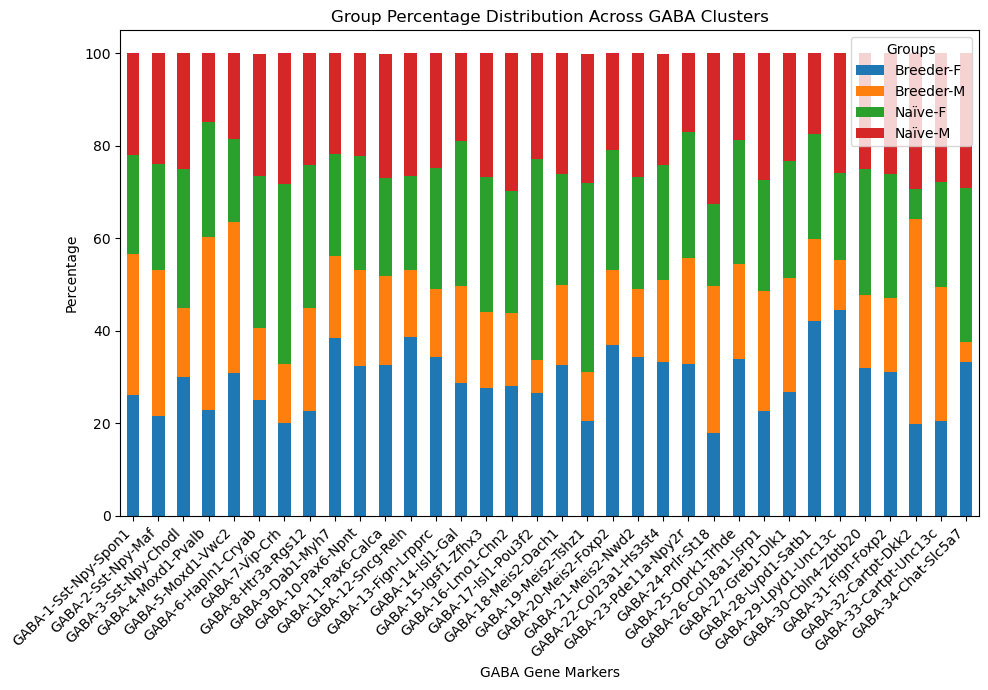

In [35]:
gaba_cluster_sex_stats_df_percentage = ss.compute_cluster_sex_stats(gaba_metadata_df, prc = True)
gaba_cluster_sex_stats_df_percentage = gaba_cluster_sex_stats_df_percentage.drop(columns=['num_sample_ids','sample_ids', 'num_cells'])
gaba_cluster_sex_stats_df_percentage.plot(kind='bar', stacked=True, figsize=(10, 7))
%matplotlib inline
plt.title('Group Percentage Distribution Across GABA Clusters')
plt.ylabel('Percentage')
plt.xlabel('GABA Gene Markers')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Groups')
plt.tight_layout()
plt.show()

In [86]:
gaba_cluster_sex_stats_df.head()

Breeder-F Breeder-M Naïve-F Naïve-M num_cells  \
full_name                                                            
GABA-1-Sst-Npy-Spon1        87       102      72      73       334   
GABA-2-Sst-Npy-Maf          62        91      66      69       288   
GABA-3-Sst-Npy-Chodl        18         9      18      15        60   
GABA-4-Moxd1-Pvalb          77       126      84      50       337   
GABA-5-Moxd1-Vwc2           55        58      32      33       178   

                     num_sample_ids  \
full_name                             
GABA-1-Sst-Npy-Spon1             16   
GABA-2-Sst-Npy-Maf               16   
GABA-3-Sst-Npy-Chodl             16   
GABA-4-Moxd1-Pvalb               16   
GABA-5-Moxd1-Vwc2                16   

                                                             sample_ids  
full_name                                                                
GABA-1-Sst-Npy-Spon1  ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...  
GABA-2-Sst-Npy-Maf    ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...  
GABA-3-Sst-Npy-Chodl  ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...  
GABA-4-Moxd1-Pvalb    ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...  
GABA-5-Moxd1-Vwc2     ['10X35_1', '10X35_2', '10X36_1', '10X36_2', '...

In [89]:
gaba_df_dlr, gaba_metadata_df_dlr, gaba_clusters_2_drop = ss.drop_low_representation_cts(gaba_cluster_sex_stats_df, df, gaba_metadata_df, min_cells=10)

In [90]:
gaba_clusters_2_drop

['GABA-3-Sst-Npy-Chodl',
 'GABA-16-Lmo1-Chn2',
 'GABA-18-Meis2-Dach1',
 'GABA-32-Cartpt-Dkk2',
 'GABA-34-Chat-Slc5a7']

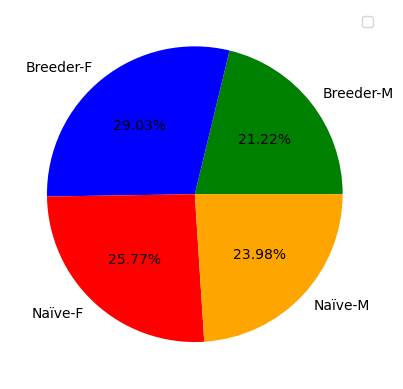

In [85]:
#check group representation at class level
gaba_class_sex_stats_df = ss.compute_class_sex_stats(gaba_metadata_df_dlr)
gaba_class_sex_stats_df_prc = gaba_class_sex_stats_df.drop(columns = ['num_sample_ids', 'sample_ids'])
gaba_class_sex_stats_df_prc.plot(kind = 'pie', subplots = True, colors = ['green','blue','red', 'orange'], autopct=lambda pct: f'{pct:.2f}%')
plt.legend([])
plt.ylabel('')
plt.show()

In [98]:
gaba_cluster_sex_stats_df.index

Index(['GABA-1-Sst-Npy-Spon1', 'GABA-2-Sst-Npy-Maf', 'GABA-3-Sst-Npy-Chodl',
       'GABA-4-Moxd1-Pvalb', 'GABA-5-Moxd1-Vwc2', 'GABA-6-Hapln1-Cryab',
       'GABA-7-Vip-Crh', 'GABA-8-Htr3a-Rgs12', 'GABA-9-Dab1-Myh7',
       'GABA-10-Pax6-Npnt', 'GABA-11-Pax6-Calca', 'GABA-12-Sncg-Reln',
       'GABA-13-Fign-Lrpprc', 'GABA-14-Isl1-Gal', 'GABA-15-Igsf1-Zfhx3',
       'GABA-16-Lmo1-Chn2', 'GABA-17-Isl1-Pou3f2', 'GABA-18-Meis2-Dach1',
       'GABA-19-Meis2-Tshz1', 'GABA-20-Meis2-Foxp2', 'GABA-21-Meis2-Nwd2',
       'GABA-22-Col23a1-Hs3st4', 'GABA-23-Pde11a-Npy2r', 'GABA-24-Prlr-St18',
       'GABA-25-Oprk1-Trhde', 'GABA-26-Col18a1-Jsrp1', 'GABA-27-Greb1-Dlk1',
       'GABA-28-Lypd1-Satb1', 'GABA-29-Lpyd1-Unc13c', 'GABA-30-Cbln4-Zbtb20',
       'GABA-31-Fign-Foxp2', 'GABA-32-Cartpt-Dkk2', 'GABA-33-Cartpt-Unc13c',
       'GABA-34-Chat-Slc5a7'],
      dtype='object', name='full_name')

In [91]:
gaba_delta_folder = '/bigdata/isaac/gaba_files/sex_stats/gene_delta_plots/171224_run/'

(7256, 223)
                   d_mf
gene                   
Gm10076        2.075804
1500009L16Rik  1.756362
Arhgap36       1.410165
Pcp4           1.084644
Lamp5          1.060004
...                 ...
Gnpda2         0.003524
Usp31          0.002830
Gna11          0.002702
Ppp2r3a        0.002158
Nfkbib         0.002043

[7256 rows x 1 columns]
yus


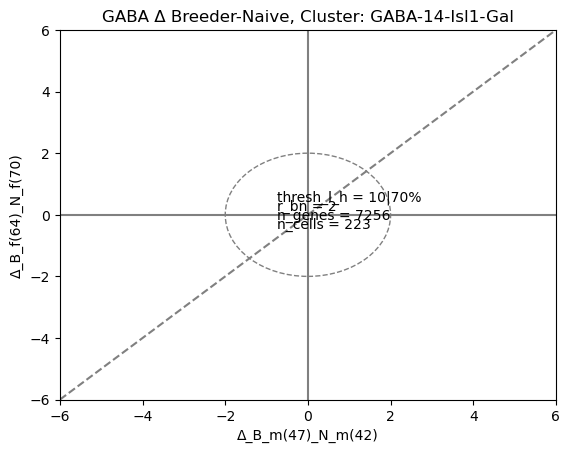

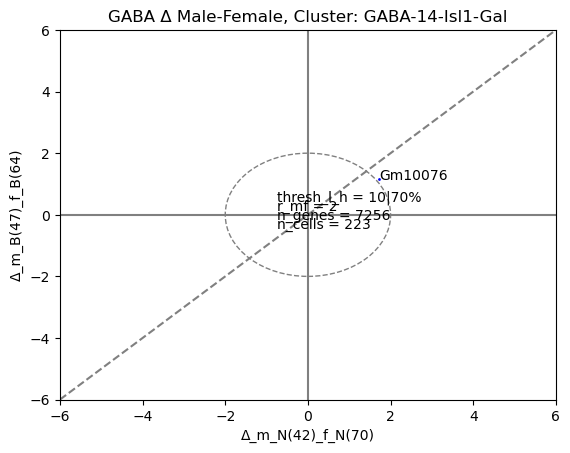

In [107]:
#test on single cluster
expr_mlog_df,counts_df = ss.compute_group_gene_expression_differences(gaba_df_dlr,
                                                            gaba_metadata_df_dlr,
                                                            cluster_fn='GABA-14-Isl1-Gal',
                                                            threshold_prc_h=70,
                                                            threshold_prc_l=10, 
                                                            r_bn = 2, 
                                                            r_mf = 2, 
                                                            cell_class='GABA', 
                                                            folder = gaba_delta_folder,
                                                            normalize = True,
                                                            n_factor = 20000,          
                                                            mode = 'delta',
                                                            sig_genes_df = None,
                                                            savefig = True, 
                                                            write_to_file=True)

In [100]:
_, idx = np.unique(gaba_metadata_df_dlr.loc['full_name'], return_index=True)
gaba_fn = np.array(gaba_metadata_df_dlr.loc['full_name'][np.sort(idx)])
gaba_fn

/tmp/ipykernel_3407519/360179944.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gaba_fn = np.array(gaba_metadata_df_dlr.loc['full_name'][np.sort(idx)])


array(['GABA-1-Sst-Npy-Spon1', 'GABA-2-Sst-Npy-Maf', 'GABA-4-Moxd1-Pvalb',
       'GABA-5-Moxd1-Vwc2', 'GABA-6-Hapln1-Cryab', 'GABA-7-Vip-Crh',
       'GABA-8-Htr3a-Rgs12', 'GABA-9-Dab1-Myh7', 'GABA-10-Pax6-Npnt',
       'GABA-11-Pax6-Calca', 'GABA-12-Sncg-Reln', 'GABA-13-Fign-Lrpprc',
       'GABA-14-Isl1-Gal', 'GABA-15-Igsf1-Zfhx3', 'GABA-17-Isl1-Pou3f2',
       'GABA-19-Meis2-Tshz1', 'GABA-20-Meis2-Foxp2', 'GABA-21-Meis2-Nwd2',
       'GABA-22-Col23a1-Hs3st4', 'GABA-23-Pde11a-Npy2r',
       'GABA-24-Prlr-St18', 'GABA-25-Oprk1-Trhde',
       'GABA-26-Col18a1-Jsrp1', 'GABA-27-Greb1-Dlk1',
       'GABA-28-Lypd1-Satb1', 'GABA-29-Lpyd1-Unc13c',
       'GABA-30-Cbln4-Zbtb20', 'GABA-31-Fign-Foxp2',
       'GABA-33-Cartpt-Unc13c'], dtype=object)

(7256, 334)
Finished processing cluster:  GABA-1-Sst-Npy-Spon1
(7256, 288)
Finished processing cluster:  GABA-2-Sst-Npy-Maf
(7256, 337)
Finished processing cluster:  GABA-4-Moxd1-Pvalb
(7256, 178)
Finished processing cluster:  GABA-5-Moxd1-Vwc2
(7256, 64)
Finished processing cluster:  GABA-6-Hapln1-Cryab
(7256, 283)
Finished processing cluster:  GABA-7-Vip-Crh
(7256, 216)
Finished processing cluster:  GABA-8-Htr3a-Rgs12
(7256, 688)
Finished processing cluster:  GABA-9-Dab1-Myh7
(7256, 145)
Finished processing cluster:  GABA-10-Pax6-Npnt
(7256, 156)
Finished processing cluster:  GABA-11-Pax6-Calca
(7256, 147)
Finished processing cluster:  GABA-12-Sncg-Reln
(7256, 230)
Finished processing cluster:  GABA-13-Fign-Lrpprc
(7256, 223)


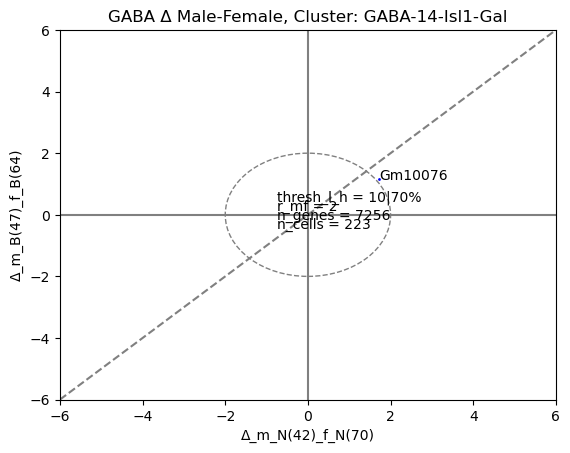

Finished processing cluster:  GABA-14-Isl1-Gal
(7256, 127)
Finished processing cluster:  GABA-15-Igsf1-Zfhx3
(7256, 166)
Finished processing cluster:  GABA-17-Isl1-Pou3f2
(7256, 447)
Finished processing cluster:  GABA-19-Meis2-Tshz1
(7256, 162)
Finished processing cluster:  GABA-20-Meis2-Foxp2
(7256, 299)
Finished processing cluster:  GABA-21-Meis2-Nwd2
(7256, 282)
Finished processing cluster:  GABA-22-Col23a1-Hs3st4
(7256, 289)
Finished processing cluster:  GABA-23-Pde11a-Npy2r
(7256, 582)
Finished processing cluster:  GABA-24-Prlr-St18
(7256, 500)
Finished processing cluster:  GABA-25-Oprk1-Trhde
(7256, 391)
Finished processing cluster:  GABA-26-Col18a1-Jsrp1
(7256, 194)
Finished processing cluster:  GABA-27-Greb1-Dlk1
(7256, 254)
Finished processing cluster:  GABA-28-Lypd1-Satb1
(7256, 278)
Finished processing cluster:  GABA-29-Lpyd1-Unc13c
(7256, 184)
Finished processing cluster:  GABA-30-Cbln4-Zbtb20
(7256, 306)
Finished processing cluster:  GABA-31-Fign-Foxp2
(7256, 458)
Finished

In [112]:
#skip first since single sample.
gaba_all_counts_df = pd.DataFrame(columns=['N_f_cnts', 'B_f_cnts','N_m_cnts','B_m_cnts'])
for c in gaba_fn:
    _,counts_df = ss.compute_group_gene_expression_differences(gaba_df_dlr,
                                                            gaba_metadata_df_dlr,
                                                            cluster_fn=c,
                                                            threshold_prc_h=70,
                                                            threshold_prc_l=10, 
                                                            r_bn = 2, 
                                                            r_mf = 2, 
                                                            cell_class='GABA', 
                                                            folder = gaba_delta_folder,
                                                            normalize = True,
                                                            n_factor = 20000,          
                                                            mode = 'delta',
                                                            sig_genes_df = None,
                                                            savefig = True, 
                                                            write_to_file=True)
    print ('Finished processing cluster: ', c)
    gaba_all_counts_df = pd.concat([gaba_all_counts_df,counts_df])
print ('Run complete, results in: ', gaba_delta_folder)

In [96]:
expr_mlog_df

N_f       B_f       N_m       B_m
gene                                                 
0610007P14Rik  0.622911  0.485801  0.706666  0.442858
0610009B22Rik  0.451525  0.293216  0.421300  0.227156
0610009L18Rik  0.091458  0.114943  0.139314  0.117647
0610009O20Rik  0.149373  0.121666  0.164384  0.137255
0610010F05Rik  0.365831  0.233791  0.527531  0.230488
...                 ...       ...       ...       ...
Zyg11b         1.011099  0.746281  1.190734  0.794727
Zzef1          0.667982  0.549996  0.718282  0.433230
Zzz3           0.329929  0.373676  0.390545  0.342400
l7Rn6          0.698938  0.474306  0.470409  0.473183
mt-Nd6         0.675881  0.480824  0.682872  0.516468

[7256 rows x 4 columns]

In [ ]:
gaba_delta_folder

'/bigdata/isaac/gaba_files/sex_stats/gene_delta_plots/171224_run/'

In [ ]:
# Mann Whitney U Test w/ False Discovery Rate <a name="u_test"></a>

gaba_delta_data_folder = gaba_delta_folder + 'data/' 
gaba_utest_output_folder  = gaba_delta_folder + 'utest_data/'
#single cluster
U_test_BN_m, U_test_BN_f, U_test_mf_B, U_test_mf_N = ss.run_stat_test(gaba_delta_data_folder,'GABA-1-Sst-Npy-Spon1',gaba_utest_output_folder,'GABA',write_to_file=True)

In [123]:
#run over all clusters
for c in gaba_fn:
    print ('running mann whitney test on cluster ', c, '...')
    _, _, _, _ = ss.run_stat_test(gaba_delta_data_folder,c,gaba_utest_output_folder,'GABA',write_to_file=True)
print('complete. results in: ', gaba_utest_output_folder)

running mann whitney test on cluster  GABA-1-Sst-Npy-Spon1 ...
running mann whitney test on cluster  GABA-2-Sst-Npy-Maf ...
running mann whitney test on cluster  GABA-4-Moxd1-Pvalb ...
running mann whitney test on cluster  GABA-5-Moxd1-Vwc2 ...
running mann whitney test on cluster  GABA-6-Hapln1-Cryab ...
running mann whitney test on cluster  GABA-7-Vip-Crh ...
running mann whitney test on cluster  GABA-8-Htr3a-Rgs12 ...
running mann whitney test on cluster  GABA-9-Dab1-Myh7 ...
running mann whitney test on cluster  GABA-10-Pax6-Npnt ...
running mann whitney test on cluster  GABA-11-Pax6-Calca ...
running mann whitney test on cluster  GABA-12-Sncg-Reln ...
running mann whitney test on cluster  GABA-13-Fign-Lrpprc ...
running mann whitney test on cluster  GABA-14-Isl1-Gal ...
running mann whitney test on cluster  GABA-15-Igsf1-Zfhx3 ...
running mann whitney test on cluster  GABA-17-Isl1-Pou3f2 ...
running mann whitney test on cluster  GABA-19-Meis2-Tshz1 ...
running mann whitney test on

In [125]:
gaba_all_counts_df

N_f_cnts B_f_cnts N_m_cnts B_m_cnts
GABA-1-Sst-Npy-Spon1         72       87       73      102
GABA-2-Sst-Npy-Maf           66       62       69       91
GABA-4-Moxd1-Pvalb           84       77       50      126
GABA-5-Moxd1-Vwc2            32       55       33       58
GABA-6-Hapln1-Cryab          21       16       17       10
GABA-7-Vip-Crh              110       57       80       36
GABA-8-Htr3a-Rgs12           67       49       52       48
GABA-9-Dab1-Myh7            153      265      149      121
GABA-10-Pax6-Npnt            36       47       32       30
GABA-11-Pax6-Calca           33       51       42       30
GABA-12-Sncg-Reln            30       57       39       21
GABA-13-Fign-Lrpprc          60       79       57       34
GABA-14-Isl1-Gal             70       64       42       47
GABA-15-Igsf1-Zfhx3          37       35       34       21
GABA-17-Isl1-Pou3f2          72       44       38       12
GABA-19-Meis2-Tshz1         183       92      125       47
GABA-20-Meis2-Foxp2          42       60       34       26
GABA-21-Meis2-Nwd2           72      103       80       44
GABA-22-Col23a1-Hs3st4       70       94       68       50
GABA-23-Pde11a-Npy2r         79       95       49       66
GABA-24-Prlr-St18           103      104      190      185
GABA-25-Oprk1-Trhde         134      170       94      102
GABA-26-Col18a1-Jsrp1        94       89      107      101
GABA-27-Greb1-Dlk1           49       52       45       48
GABA-28-Lypd1-Satb1          58      107       44       45
GABA-29-Lpyd1-Unc13c         52      124       72       30
GABA-30-Cbln4-Zbtb20         50       59       46       29
GABA-31-Fign-Foxp2           82       95       80       49
GABA-33-Cartpt-Unc13c       104       94      127      133

In [126]:
gaba_clusters_2_drop

['GABA-3-Sst-Npy-Chodl',
 'GABA-16-Lmo1-Chn2',
 'GABA-18-Meis2-Dach1',
 'GABA-32-Cartpt-Dkk2',
 'GABA-34-Chat-Slc5a7']

<Figure size 640x480 with 0 Axes>

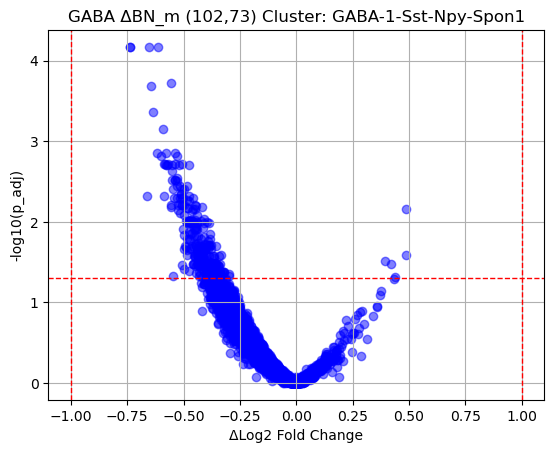

<Figure size 640x480 with 0 Axes>

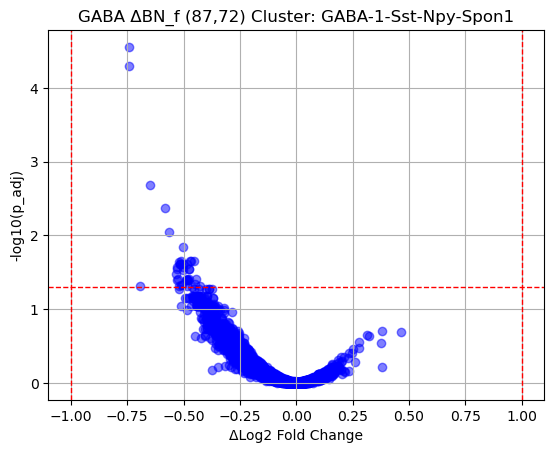

<Figure size 640x480 with 0 Axes>

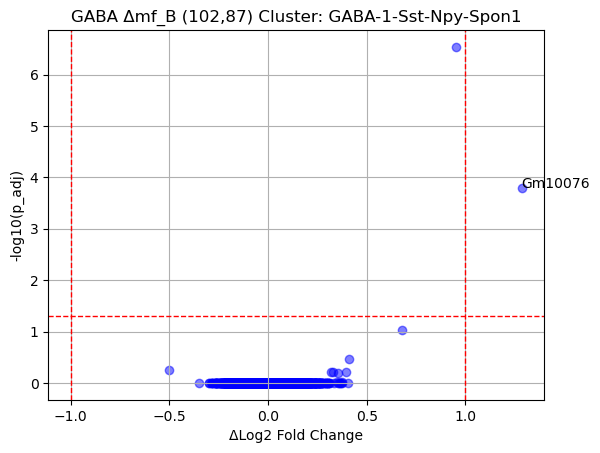

<Figure size 640x480 with 0 Axes>

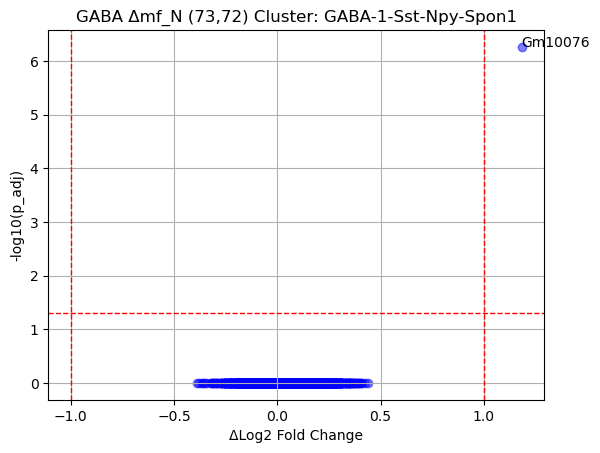

In [131]:
#run volcano, single cluster
%matplotlib inline
cell_class = 'GABA'

gaba_volcano_output_folder = '/bigdata/isaac/gaba_files/sex_stats/volcano_plots/171224_run/'

v_BN_m, v_BN_f, v_mf_B, v_mf_N = ss.run_volcano_analysis(gaba_delta_data_folder, gaba_utest_output_folder,gaba_volcano_output_folder, 'GABA-1-Sst-Npy-Spon1', 'GABA', gaba_all_counts_df, savefig = True, write_to_file = True)

running volcano analysis on cluster  GABA-1-Sst-Npy-Spon1 ...


<Figure size 640x480 with 0 Axes>

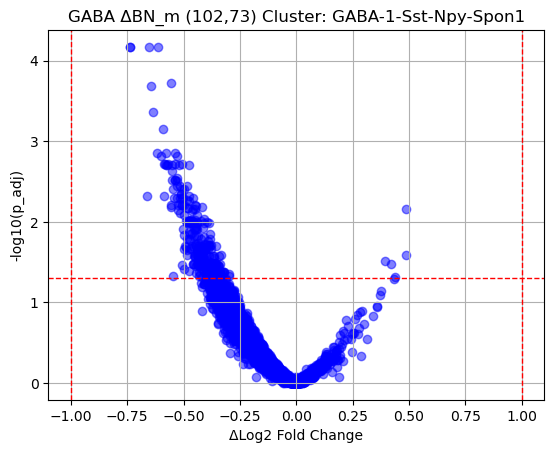

<Figure size 640x480 with 0 Axes>

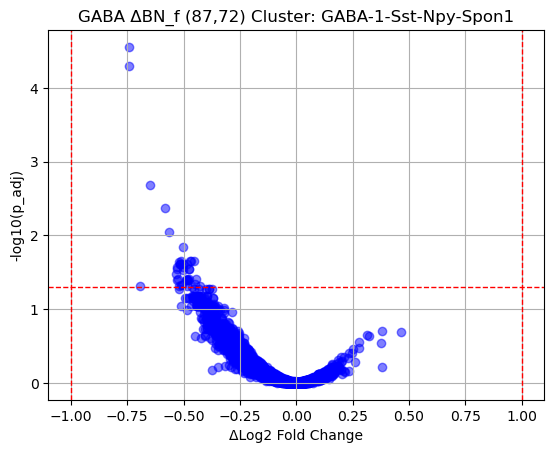

<Figure size 640x480 with 0 Axes>

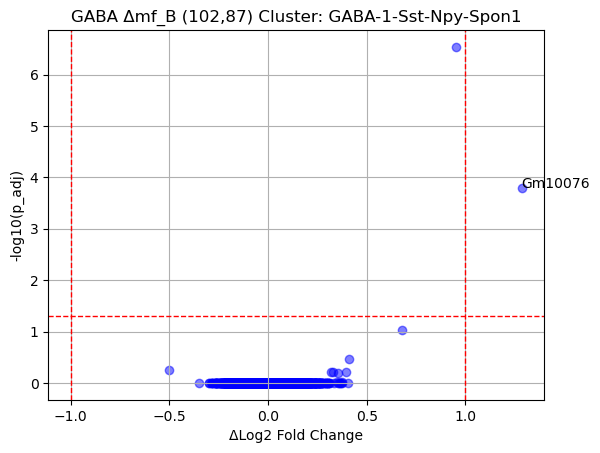

<Figure size 640x480 with 0 Axes>

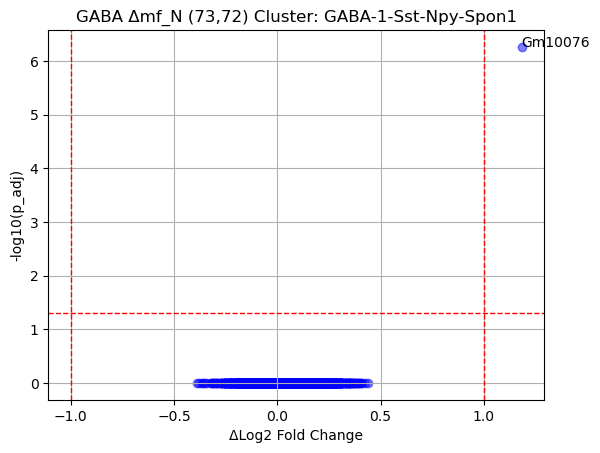

running volcano analysis on cluster  GABA-2-Sst-Npy-Maf ...


<Figure size 640x480 with 0 Axes>

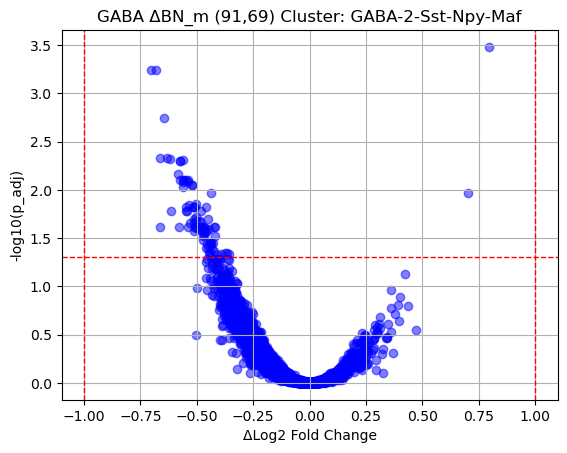

<Figure size 640x480 with 0 Axes>

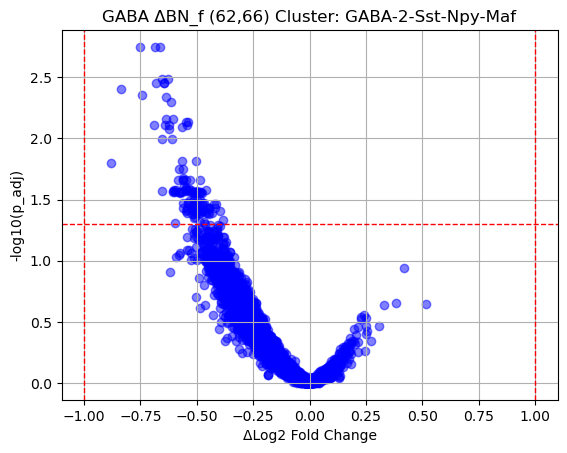

<Figure size 640x480 with 0 Axes>

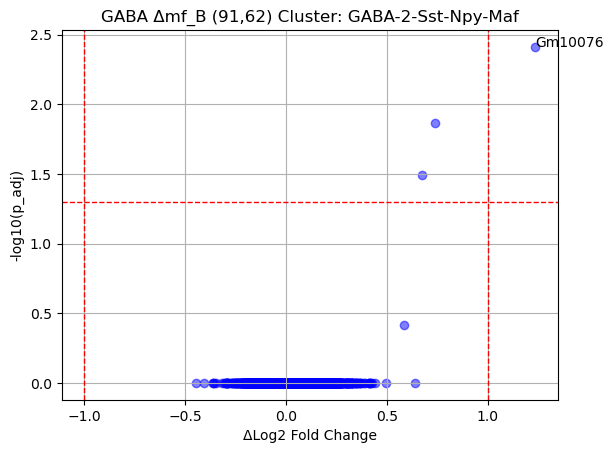

<Figure size 640x480 with 0 Axes>

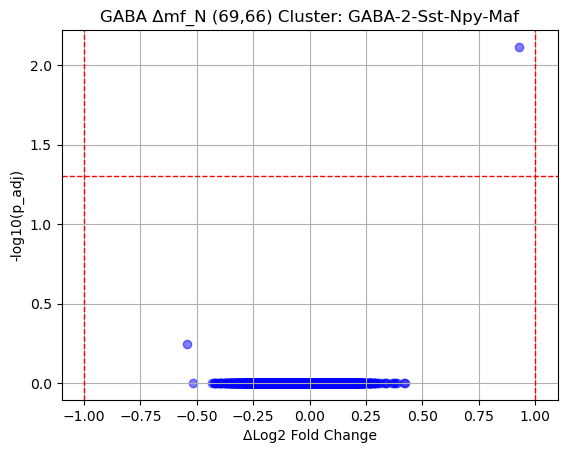

running volcano analysis on cluster  GABA-4-Moxd1-Pvalb ...


<Figure size 640x480 with 0 Axes>

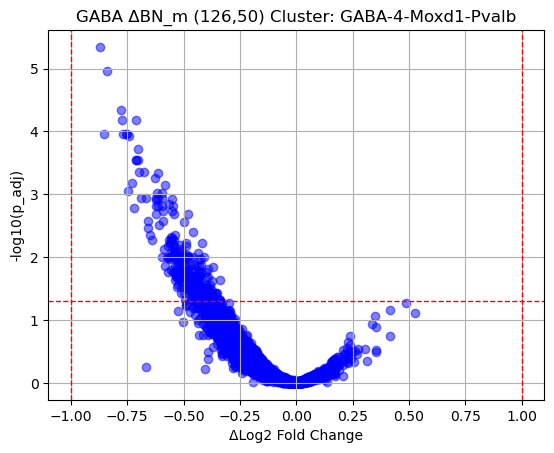

<Figure size 640x480 with 0 Axes>

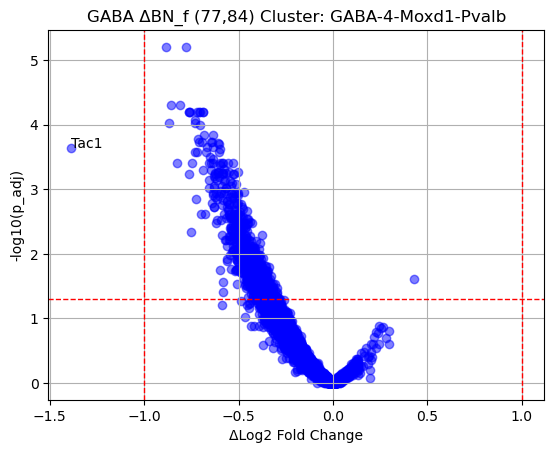

<Figure size 640x480 with 0 Axes>

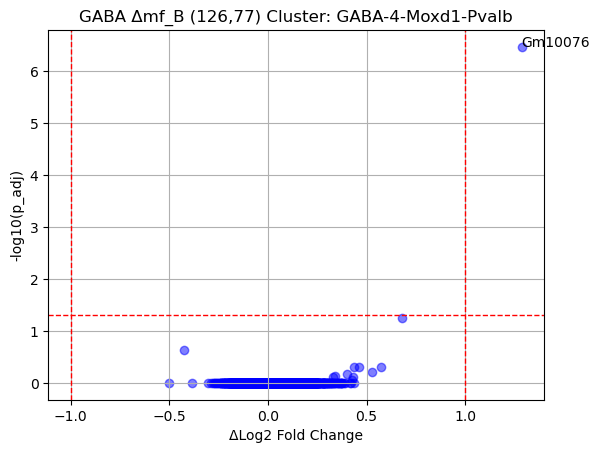

<Figure size 640x480 with 0 Axes>

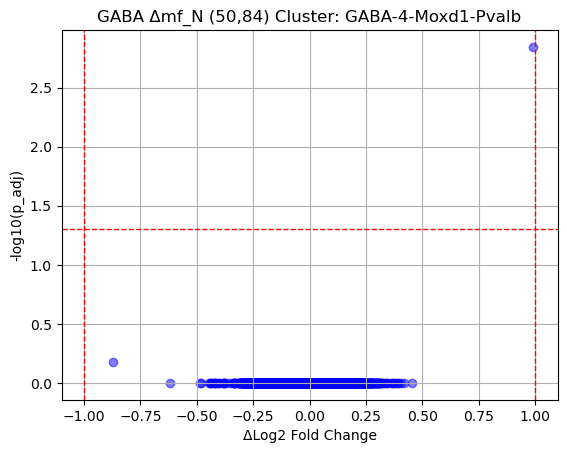

running volcano analysis on cluster  GABA-5-Moxd1-Vwc2 ...


<Figure size 640x480 with 0 Axes>

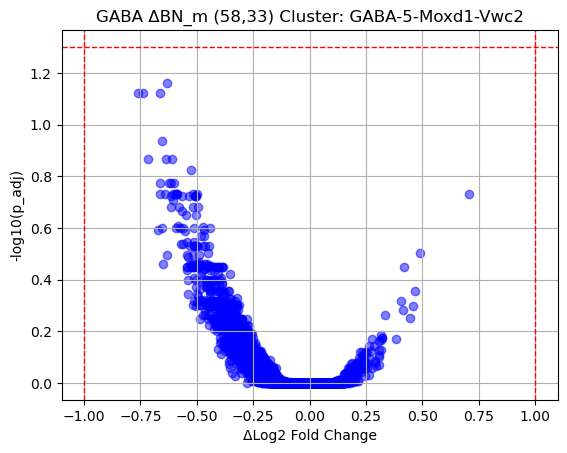

<Figure size 640x480 with 0 Axes>

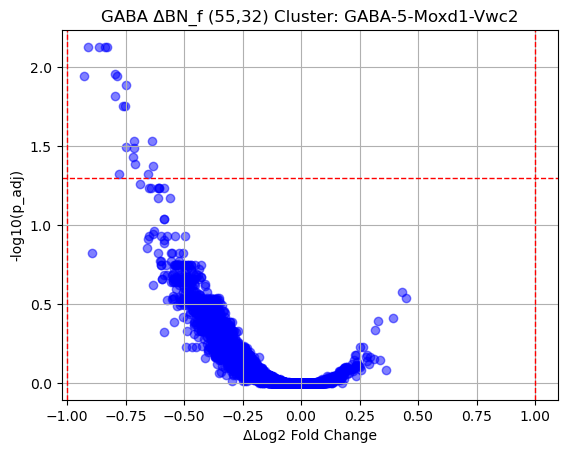

<Figure size 640x480 with 0 Axes>

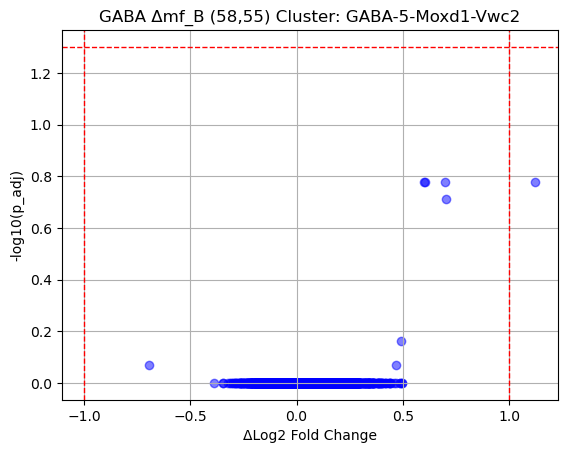

<Figure size 640x480 with 0 Axes>

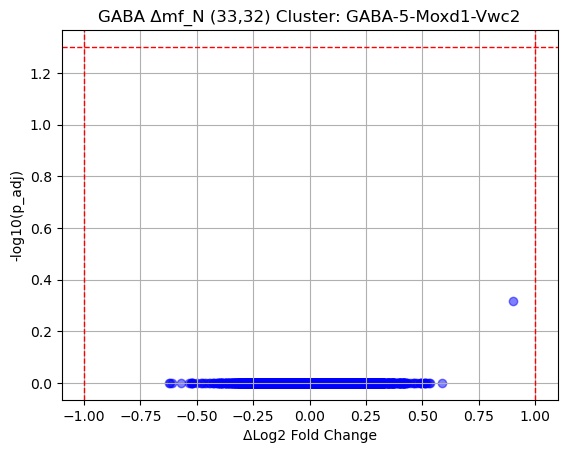

running volcano analysis on cluster  GABA-6-Hapln1-Cryab ...


<Figure size 640x480 with 0 Axes>

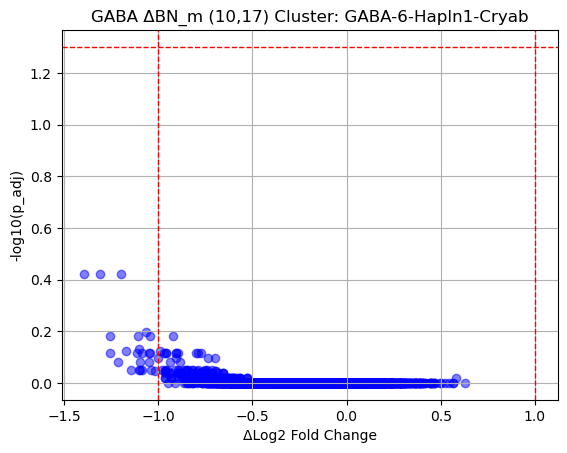

<Figure size 640x480 with 0 Axes>

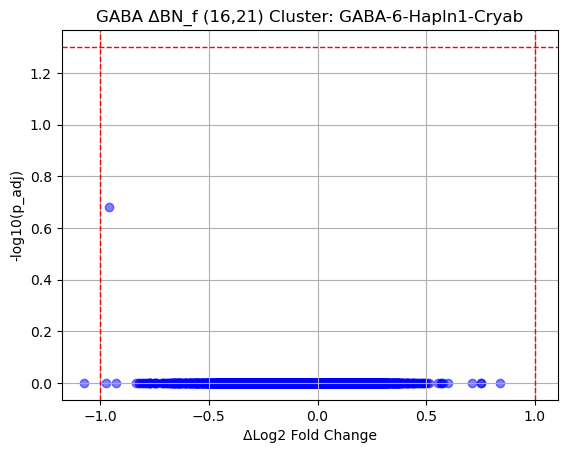

<Figure size 640x480 with 0 Axes>

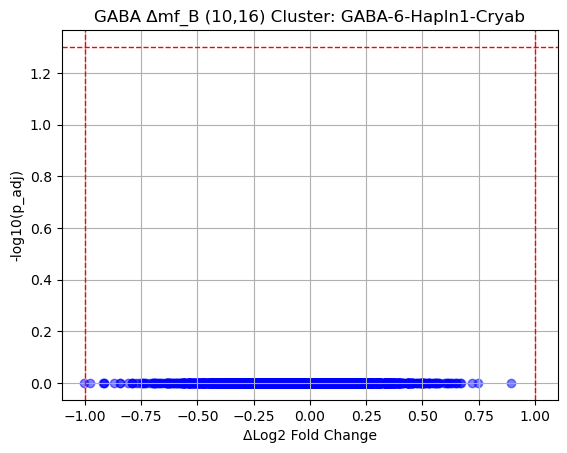

<Figure size 640x480 with 0 Axes>

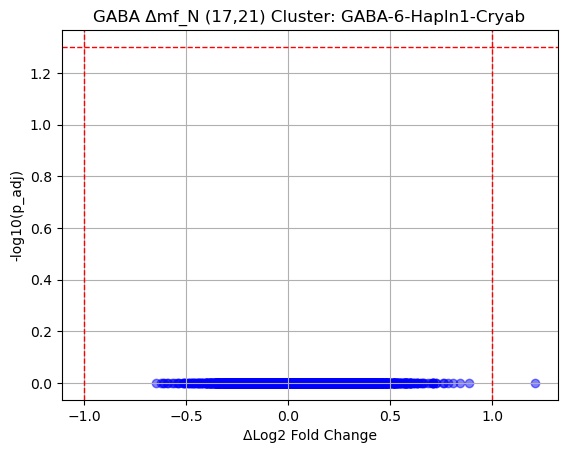

running volcano analysis on cluster  GABA-7-Vip-Crh ...


<Figure size 640x480 with 0 Axes>

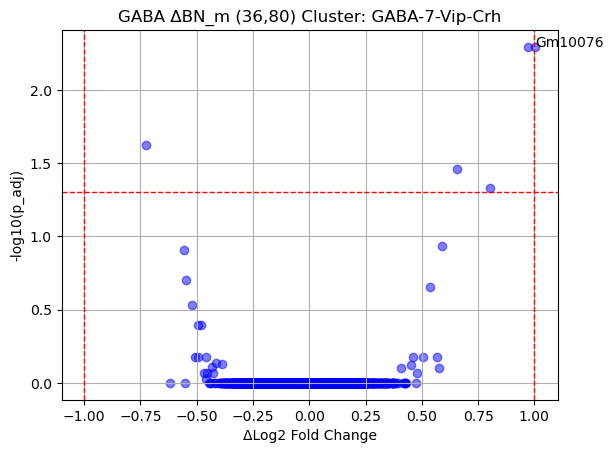

<Figure size 640x480 with 0 Axes>

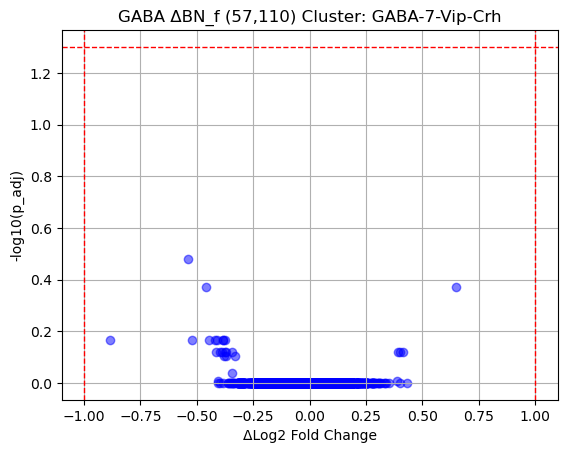

<Figure size 640x480 with 0 Axes>

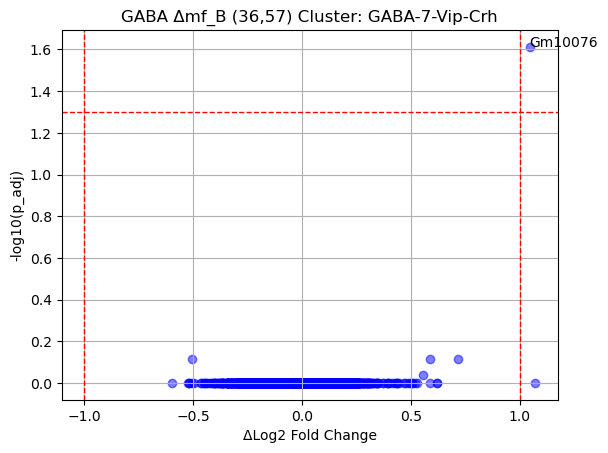

<Figure size 640x480 with 0 Axes>

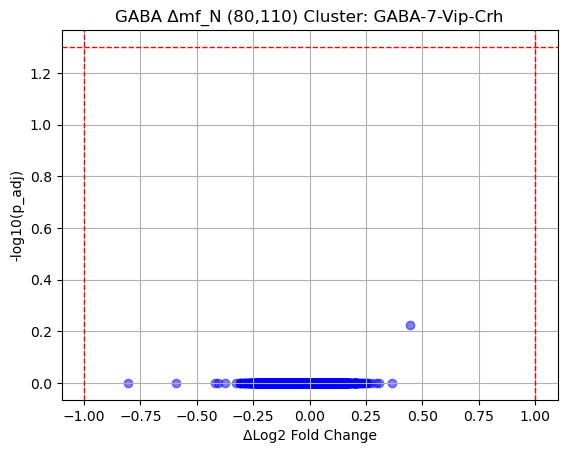

running volcano analysis on cluster  GABA-8-Htr3a-Rgs12 ...


<Figure size 640x480 with 0 Axes>

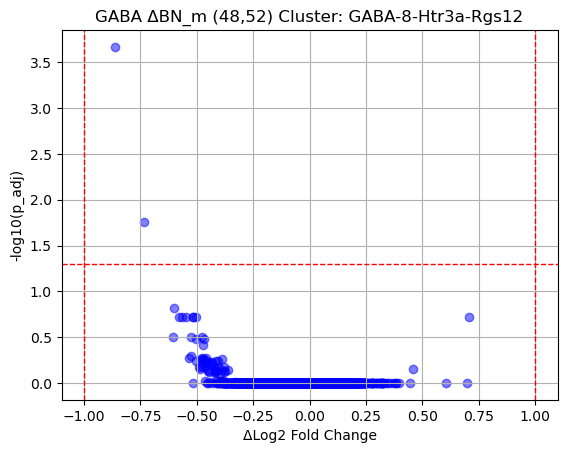

<Figure size 640x480 with 0 Axes>

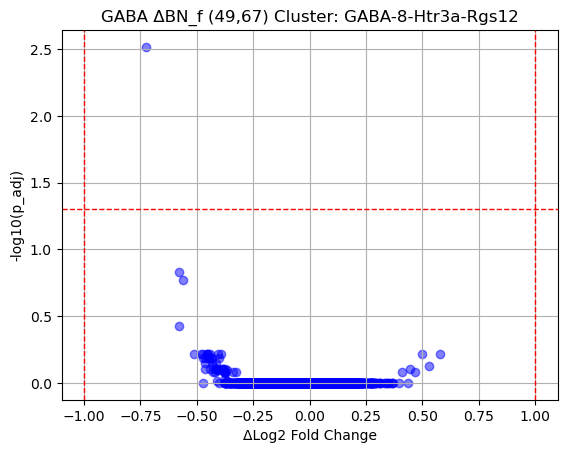

<Figure size 640x480 with 0 Axes>

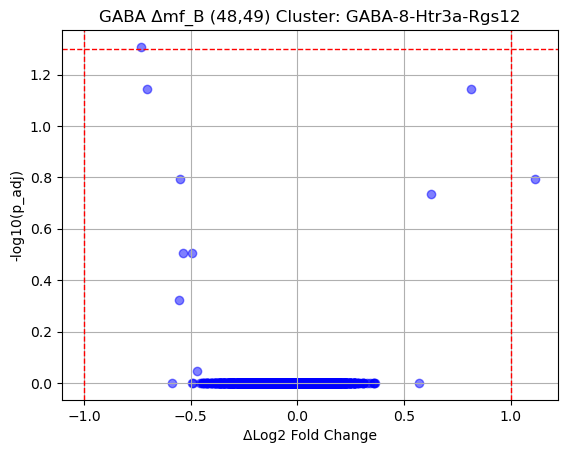

<Figure size 640x480 with 0 Axes>

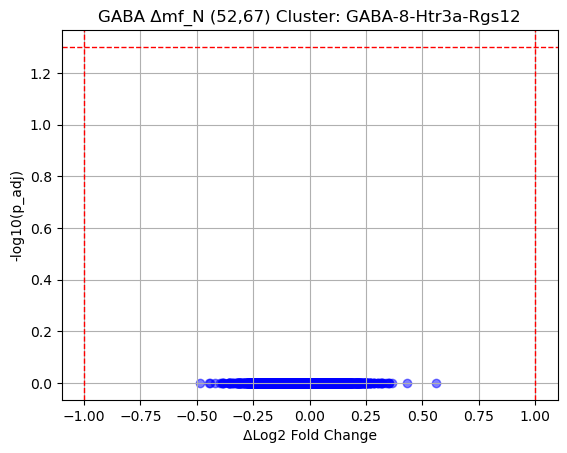

running volcano analysis on cluster  GABA-9-Dab1-Myh7 ...


<Figure size 640x480 with 0 Axes>

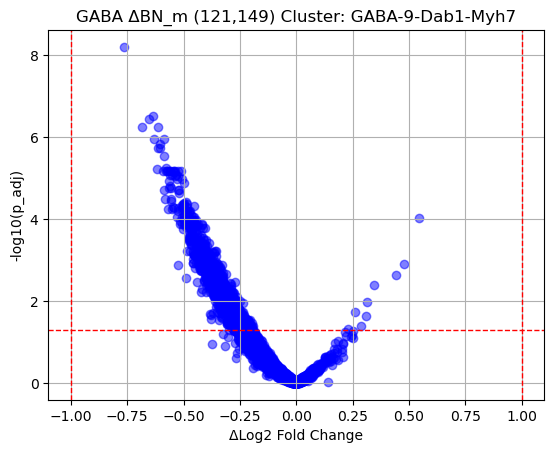

<Figure size 640x480 with 0 Axes>

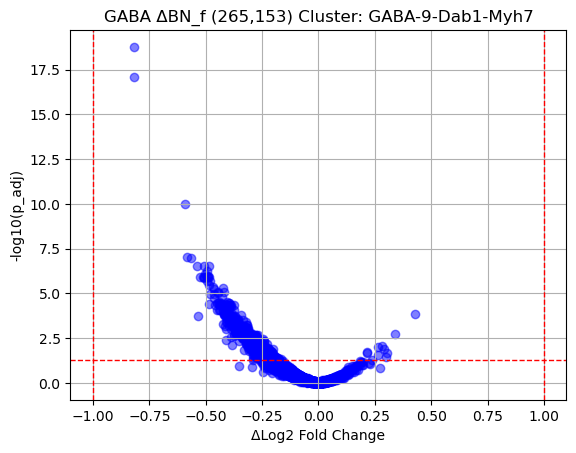

<Figure size 640x480 with 0 Axes>

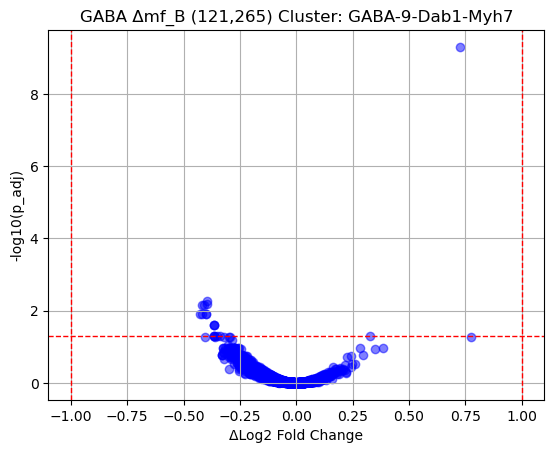

<Figure size 640x480 with 0 Axes>

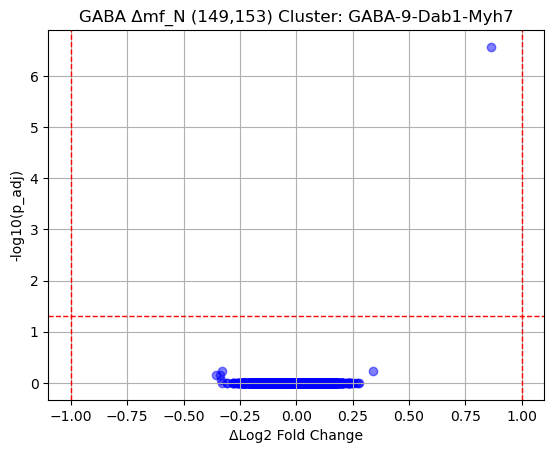

running volcano analysis on cluster  GABA-10-Pax6-Npnt ...


<Figure size 640x480 with 0 Axes>

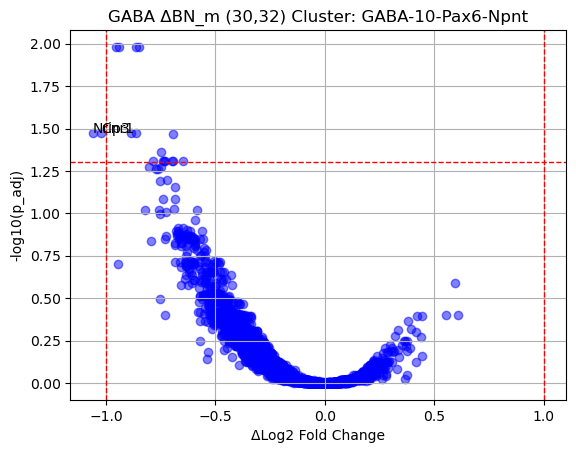

<Figure size 640x480 with 0 Axes>

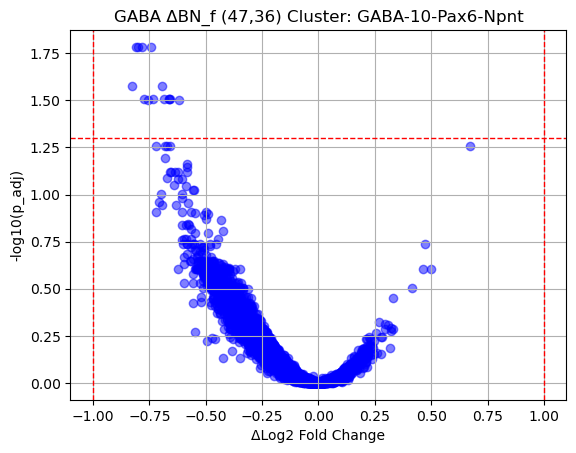

<Figure size 640x480 with 0 Axes>

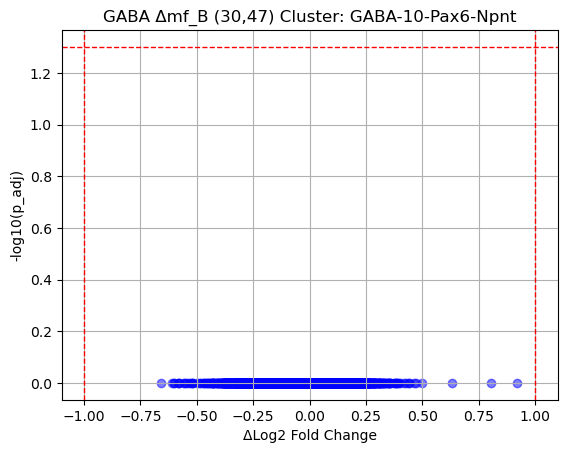

<Figure size 640x480 with 0 Axes>

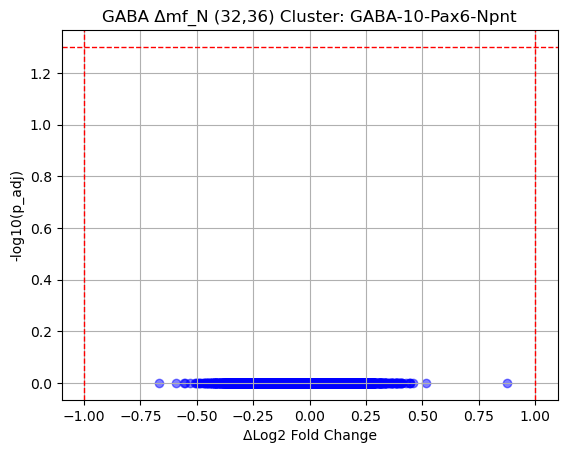

running volcano analysis on cluster  GABA-11-Pax6-Calca ...


<Figure size 640x480 with 0 Axes>

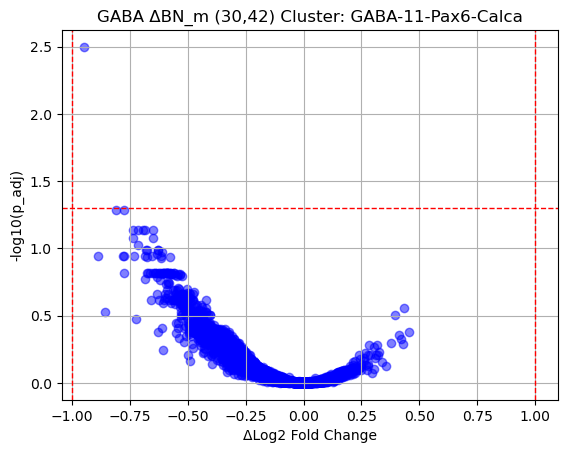

<Figure size 640x480 with 0 Axes>

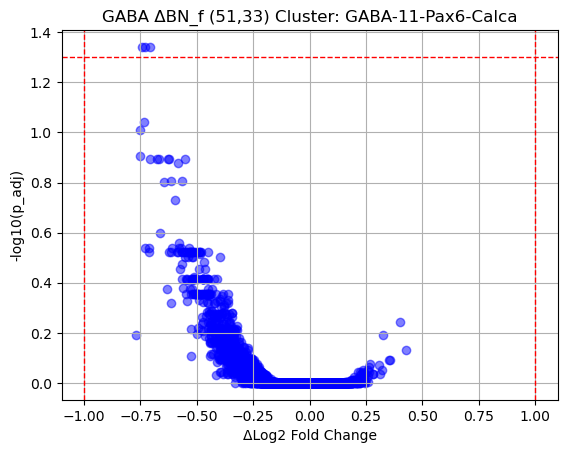

<Figure size 640x480 with 0 Axes>

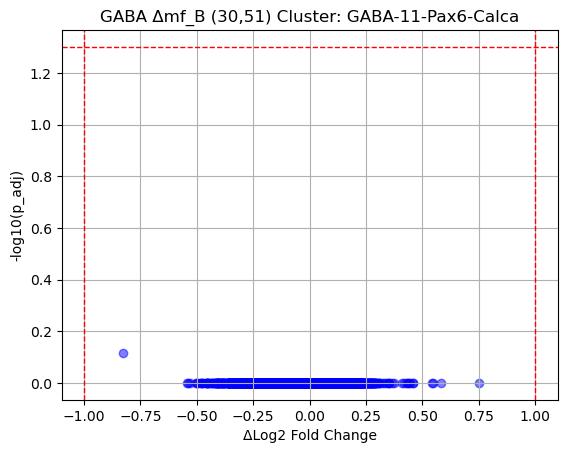

<Figure size 640x480 with 0 Axes>

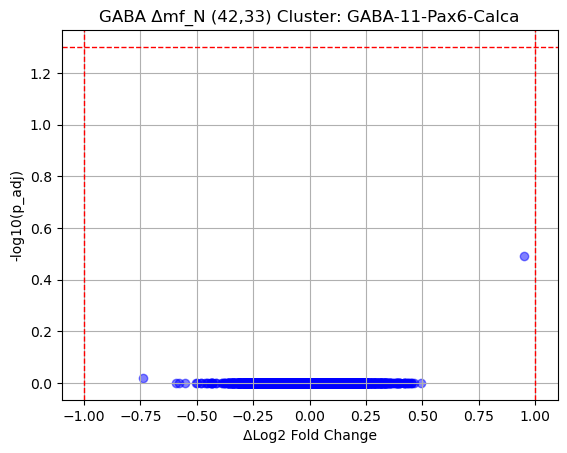

running volcano analysis on cluster  GABA-12-Sncg-Reln ...


<Figure size 640x480 with 0 Axes>

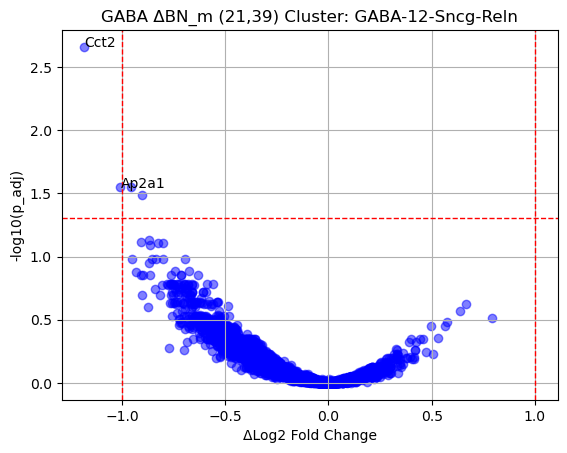

<Figure size 640x480 with 0 Axes>

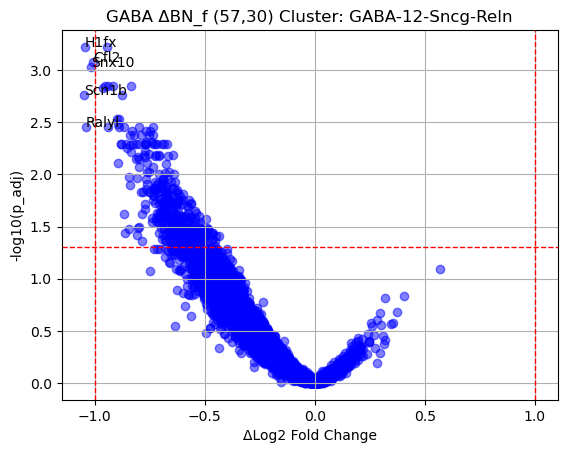

<Figure size 640x480 with 0 Axes>

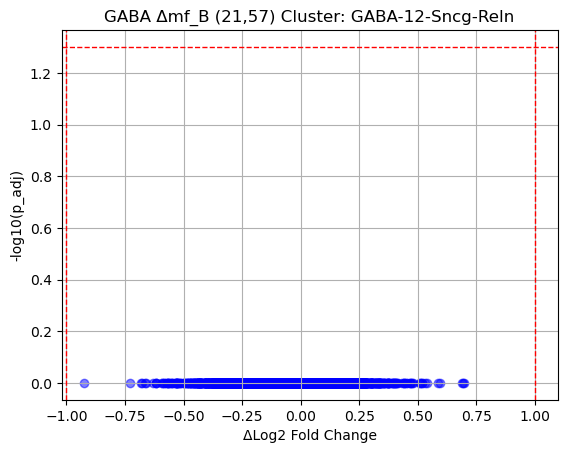

<Figure size 640x480 with 0 Axes>

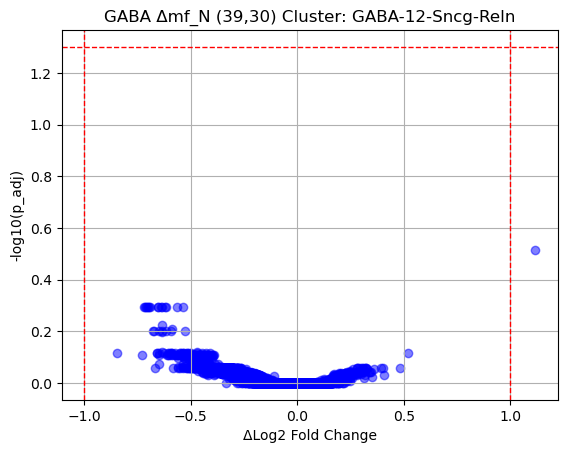

running volcano analysis on cluster  GABA-13-Fign-Lrpprc ...


<Figure size 640x480 with 0 Axes>

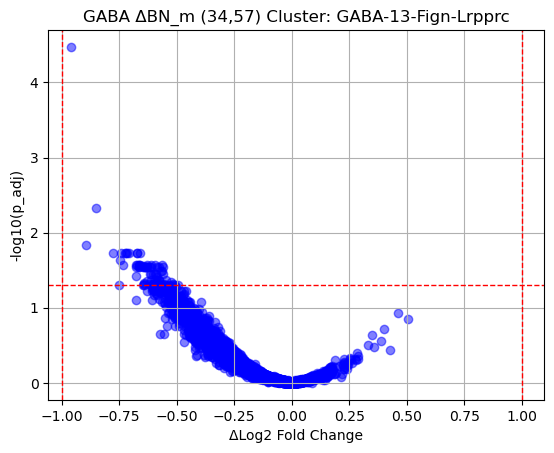

<Figure size 640x480 with 0 Axes>

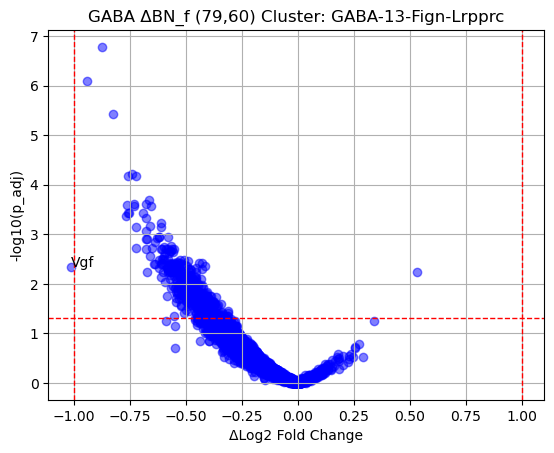

<Figure size 640x480 with 0 Axes>

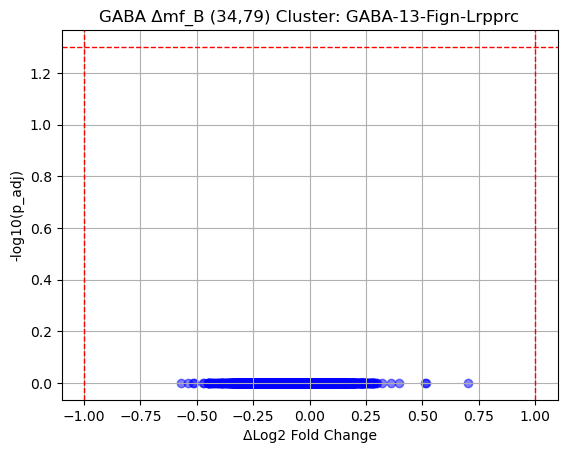

<Figure size 640x480 with 0 Axes>

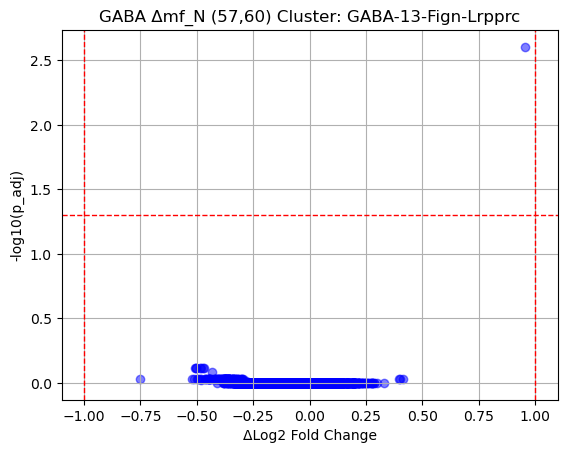

running volcano analysis on cluster  GABA-14-Isl1-Gal ...


<Figure size 640x480 with 0 Axes>

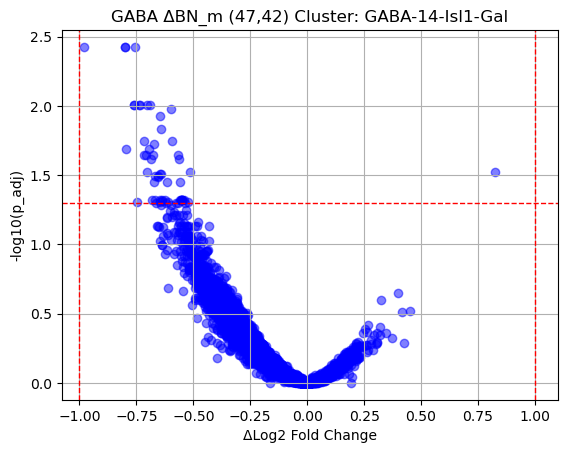

<Figure size 640x480 with 0 Axes>

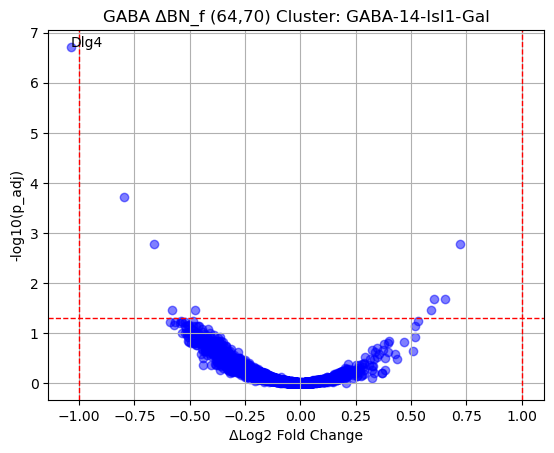

<Figure size 640x480 with 0 Axes>

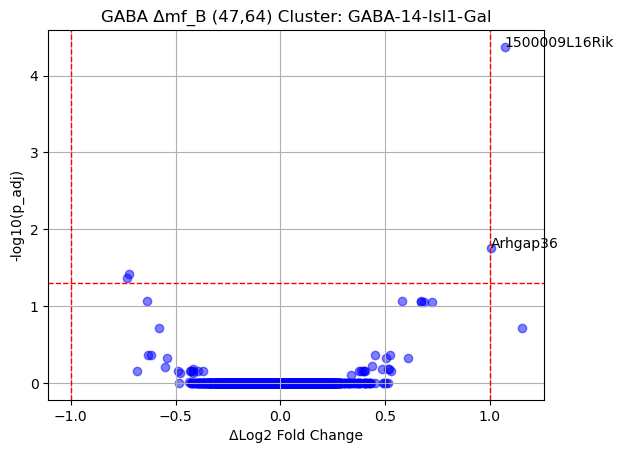

<Figure size 640x480 with 0 Axes>

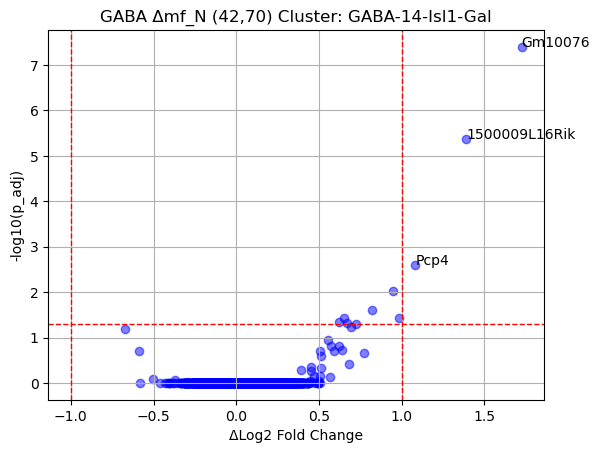

running volcano analysis on cluster  GABA-15-Igsf1-Zfhx3 ...


<Figure size 640x480 with 0 Axes>

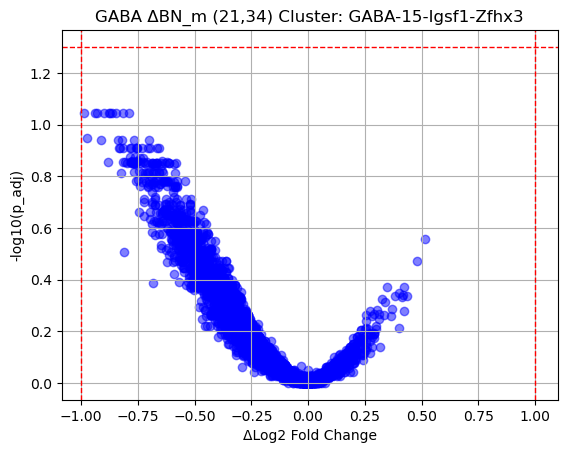

<Figure size 640x480 with 0 Axes>

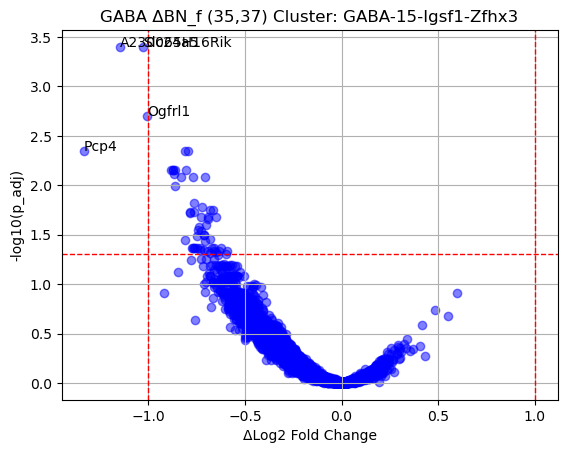

<Figure size 640x480 with 0 Axes>

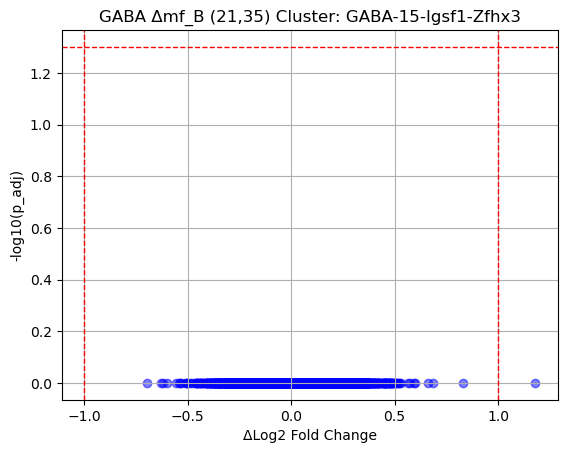

<Figure size 640x480 with 0 Axes>

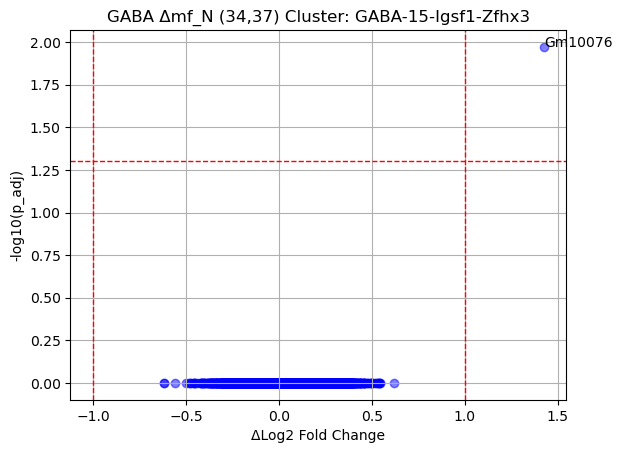

running volcano analysis on cluster  GABA-17-Isl1-Pou3f2 ...


<Figure size 640x480 with 0 Axes>

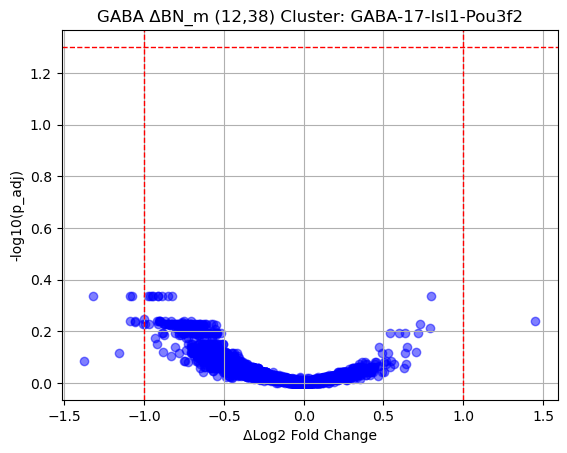

<Figure size 640x480 with 0 Axes>

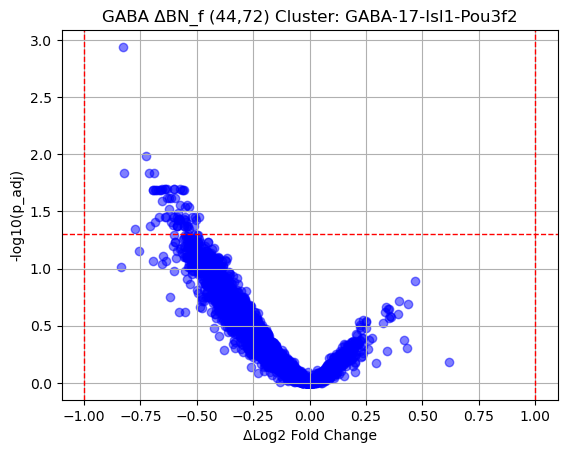

<Figure size 640x480 with 0 Axes>

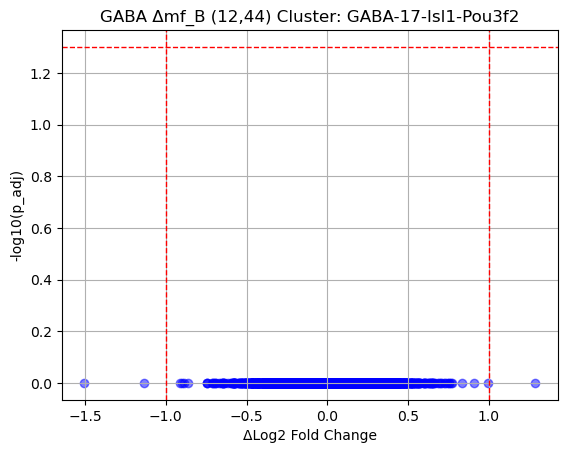

<Figure size 640x480 with 0 Axes>

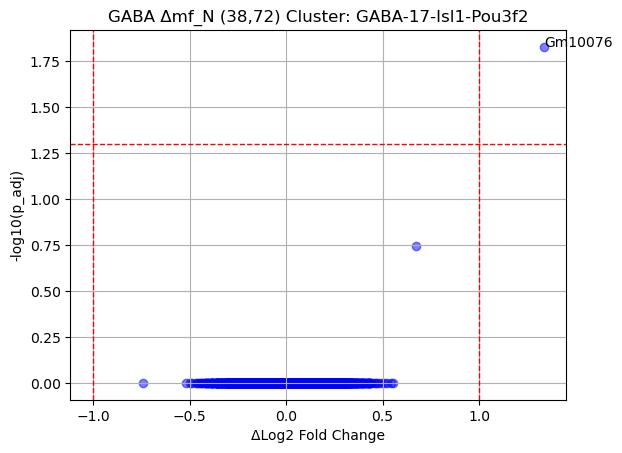

running volcano analysis on cluster  GABA-19-Meis2-Tshz1 ...


<Figure size 640x480 with 0 Axes>

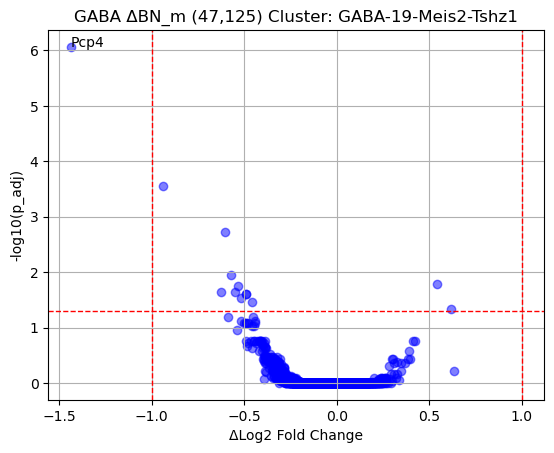

<Figure size 640x480 with 0 Axes>

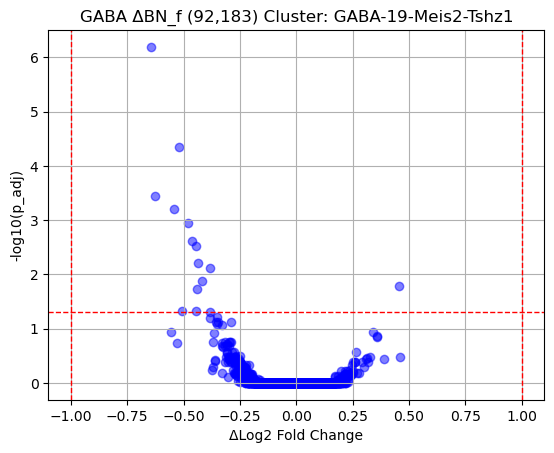

<Figure size 640x480 with 0 Axes>

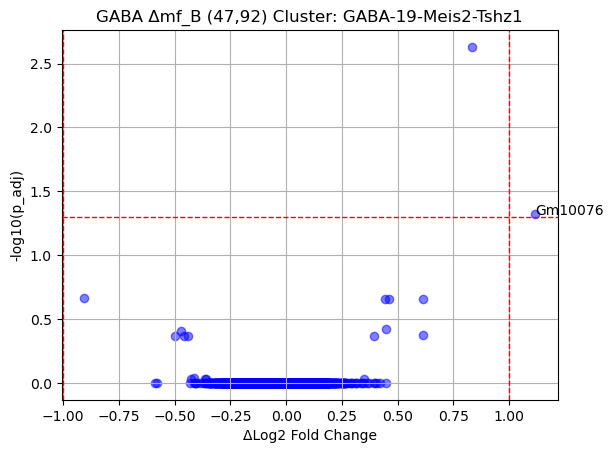

<Figure size 640x480 with 0 Axes>

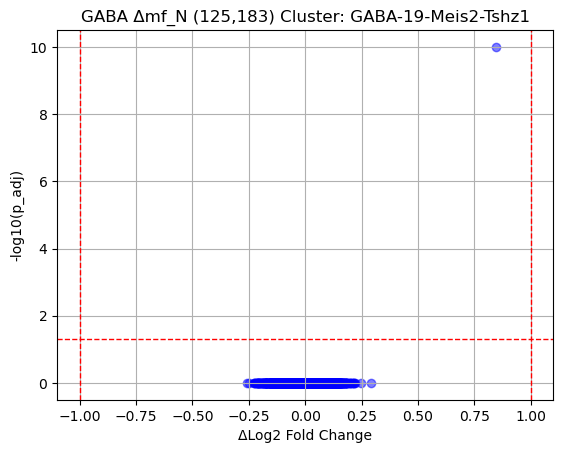

running volcano analysis on cluster  GABA-20-Meis2-Foxp2 ...


<Figure size 640x480 with 0 Axes>

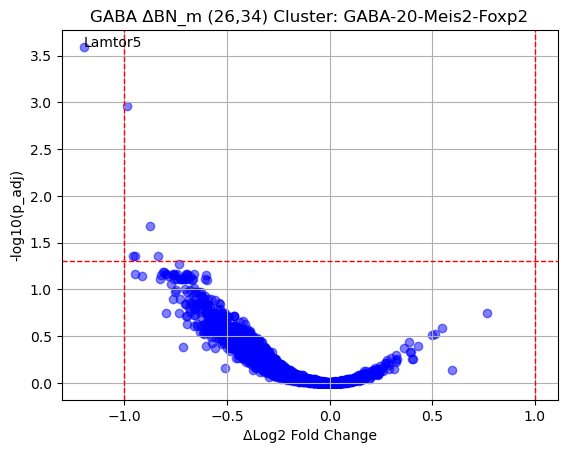

<Figure size 640x480 with 0 Axes>

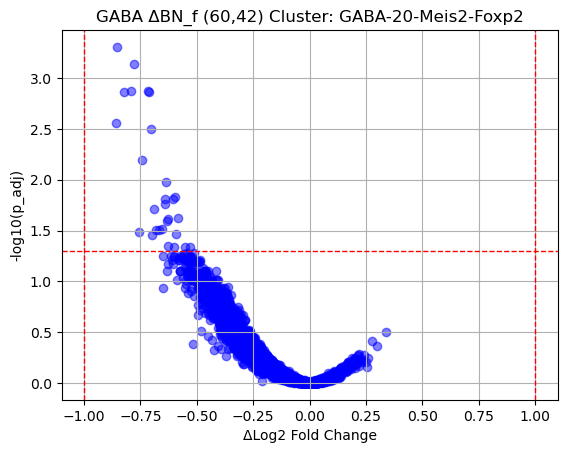

<Figure size 640x480 with 0 Axes>

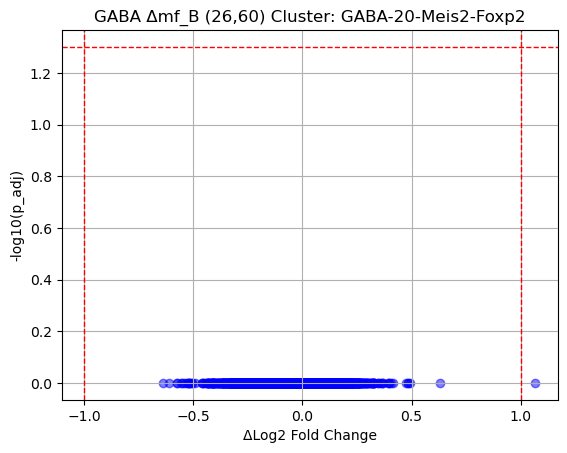

<Figure size 640x480 with 0 Axes>

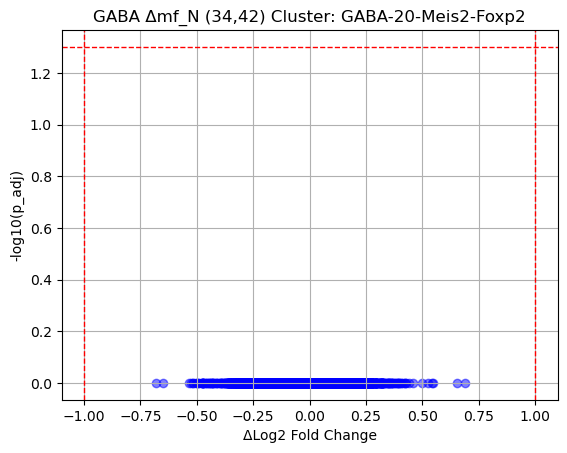

running volcano analysis on cluster  GABA-21-Meis2-Nwd2 ...


<Figure size 640x480 with 0 Axes>

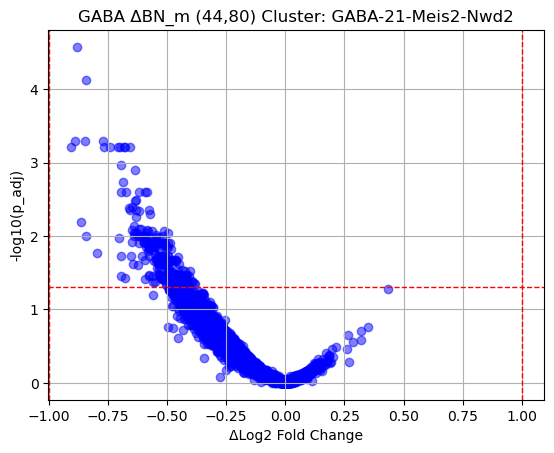

<Figure size 640x480 with 0 Axes>

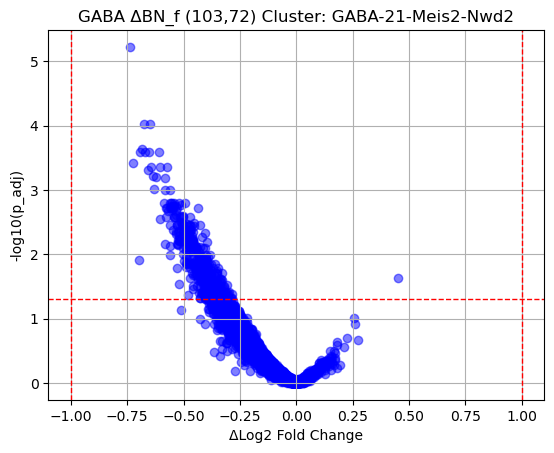

<Figure size 640x480 with 0 Axes>

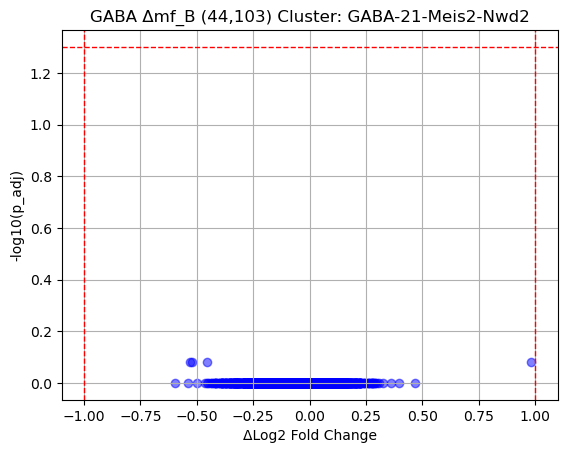

<Figure size 640x480 with 0 Axes>

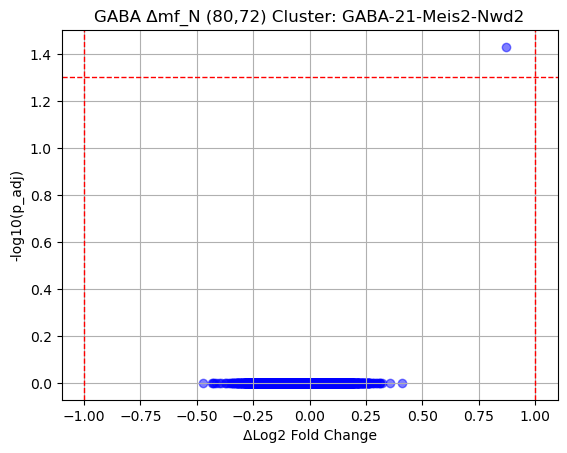

running volcano analysis on cluster  GABA-22-Col23a1-Hs3st4 ...


<Figure size 640x480 with 0 Axes>

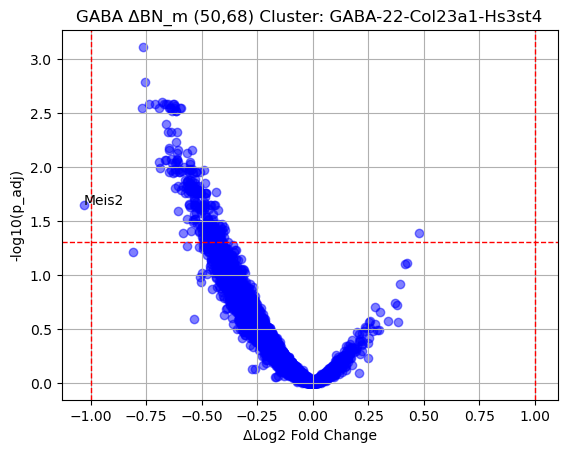

<Figure size 640x480 with 0 Axes>

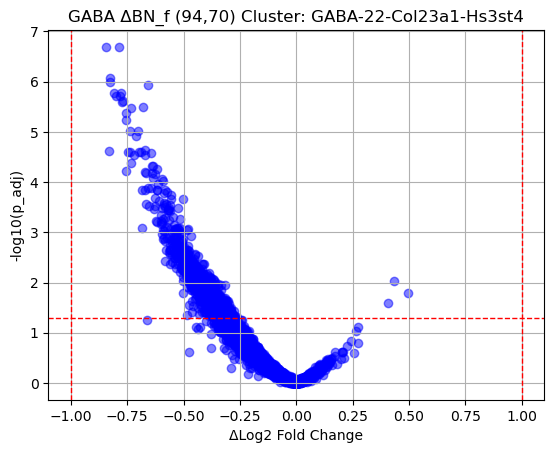

<Figure size 640x480 with 0 Axes>

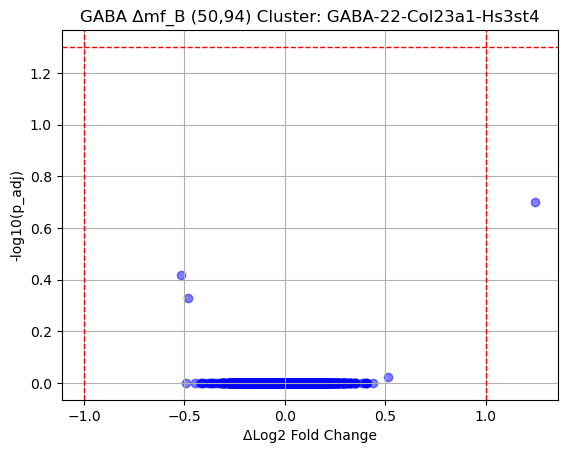

<Figure size 640x480 with 0 Axes>

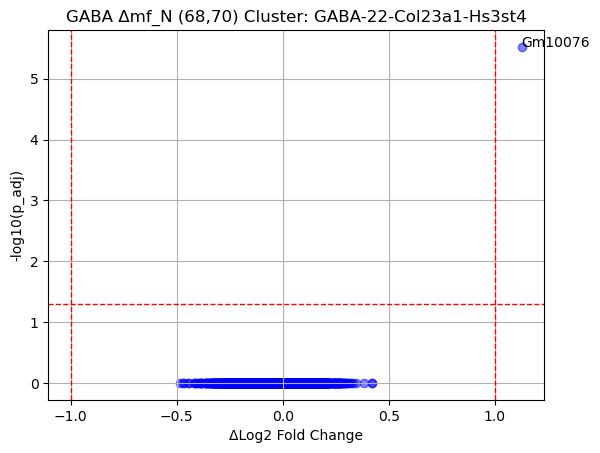

running volcano analysis on cluster  GABA-23-Pde11a-Npy2r ...


<Figure size 640x480 with 0 Axes>

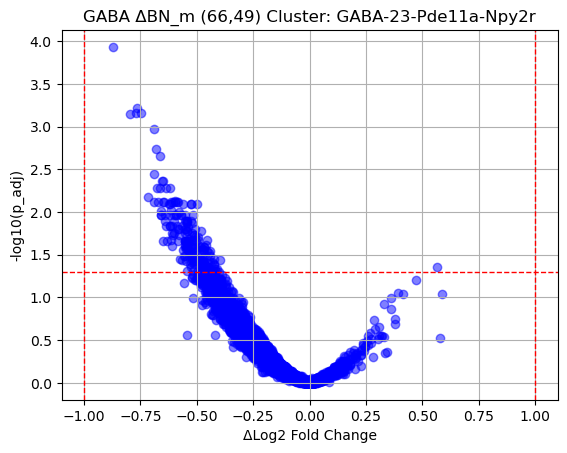

<Figure size 640x480 with 0 Axes>

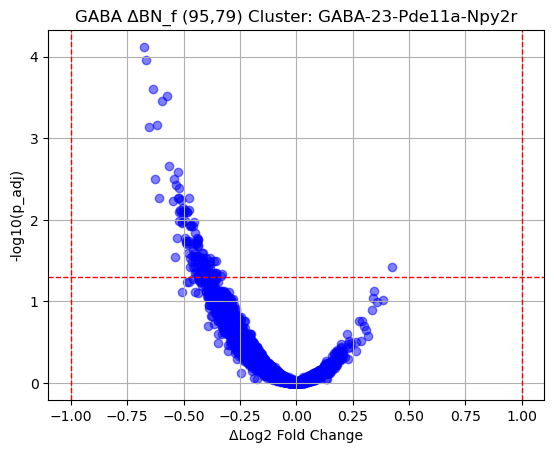

<Figure size 640x480 with 0 Axes>

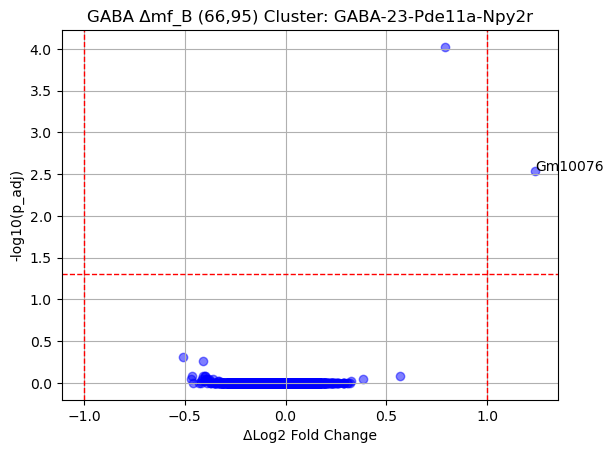

<Figure size 640x480 with 0 Axes>

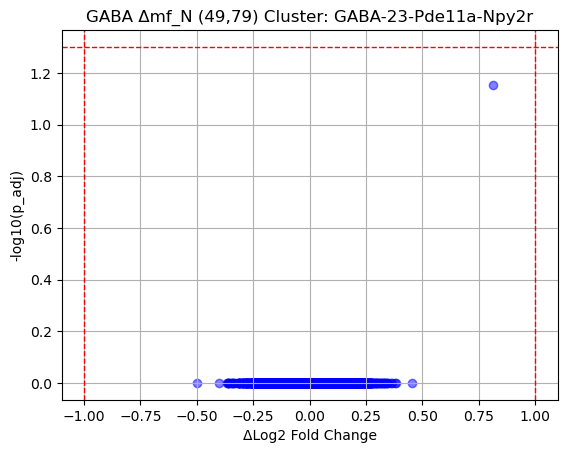

running volcano analysis on cluster  GABA-24-Prlr-St18 ...


<Figure size 640x480 with 0 Axes>

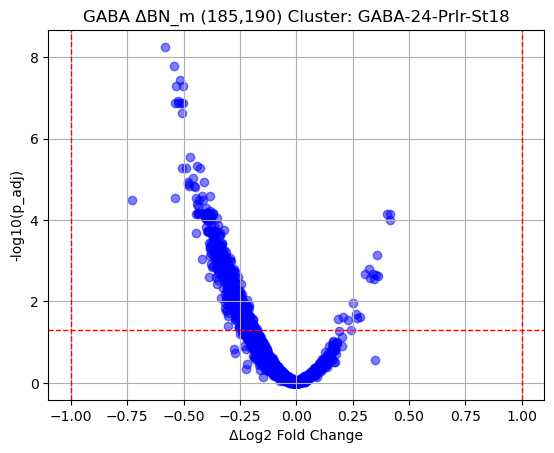

<Figure size 640x480 with 0 Axes>

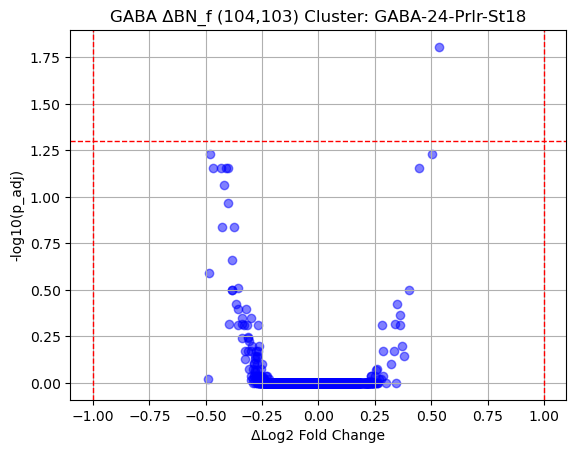

/home/isaac/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

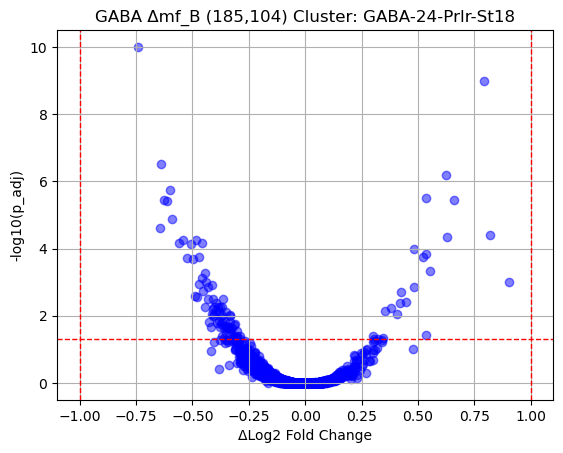

/home/isaac/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

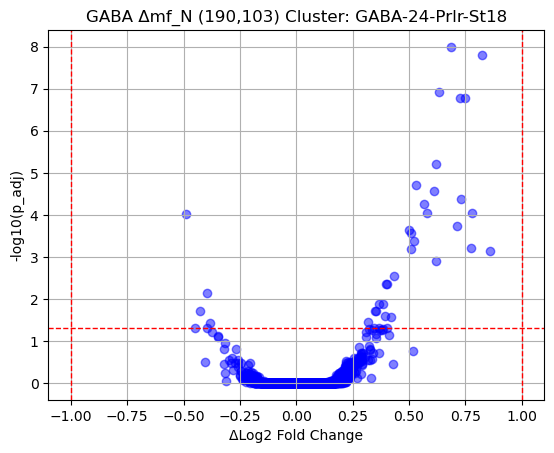

running volcano analysis on cluster  GABA-25-Oprk1-Trhde ...


<Figure size 640x480 with 0 Axes>

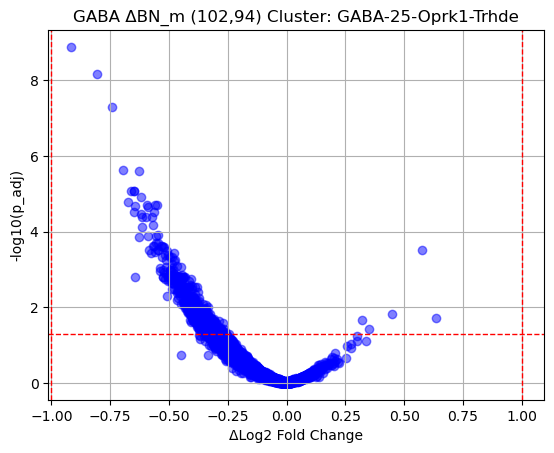

<Figure size 640x480 with 0 Axes>

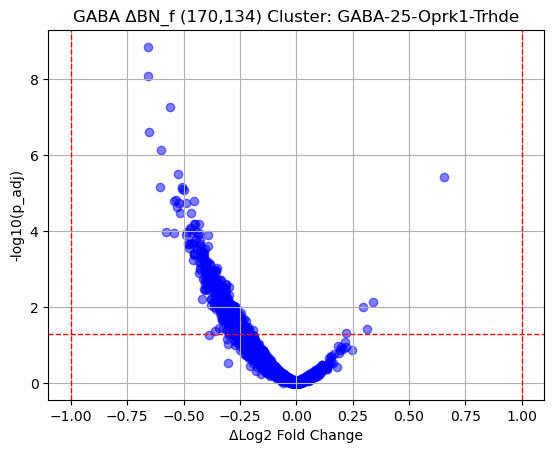

/home/isaac/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

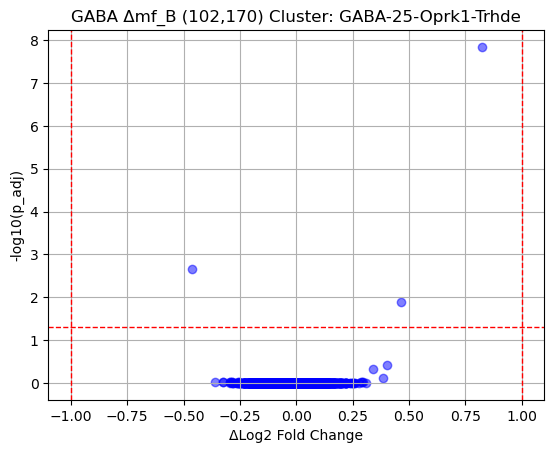

/home/isaac/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

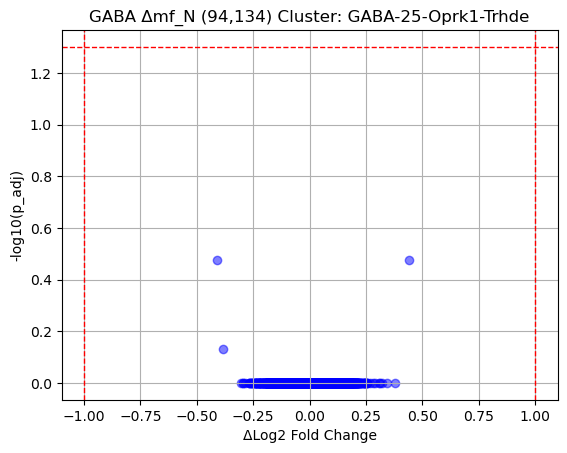

running volcano analysis on cluster  GABA-26-Col18a1-Jsrp1 ...


<Figure size 640x480 with 0 Axes>

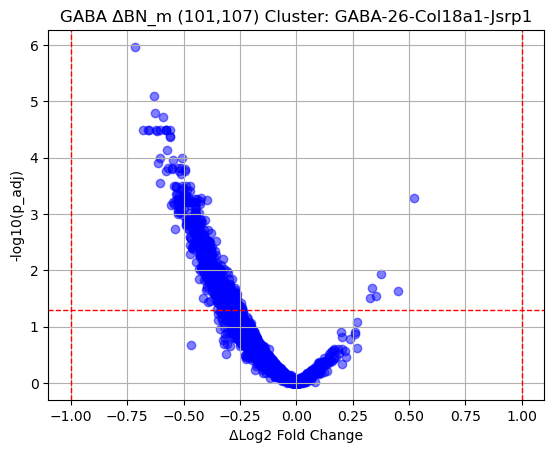

<Figure size 640x480 with 0 Axes>

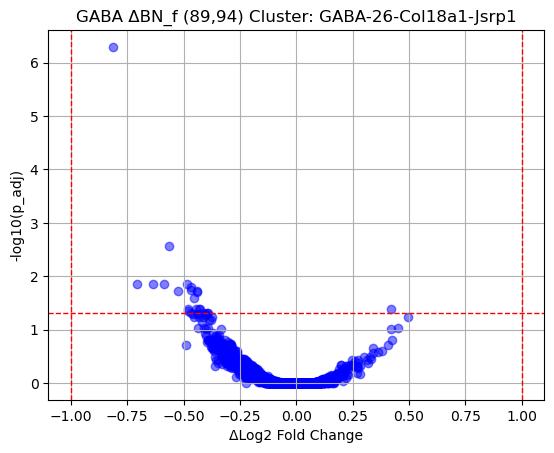

<Figure size 640x480 with 0 Axes>

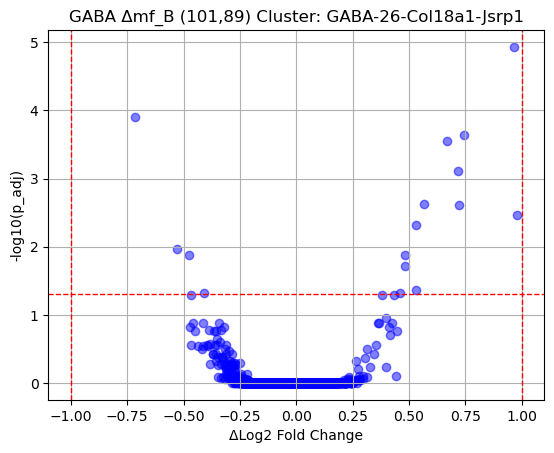

/home/isaac/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

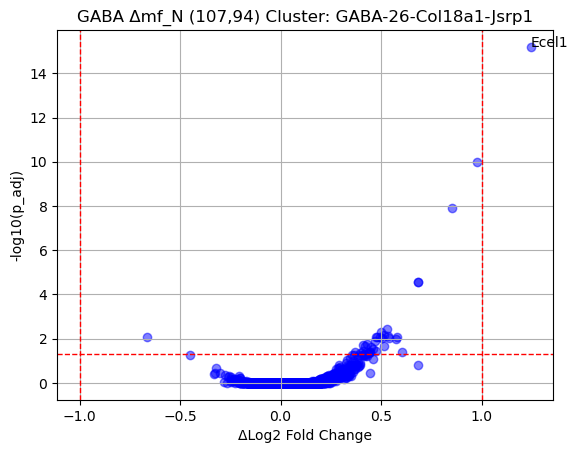

running volcano analysis on cluster  GABA-27-Greb1-Dlk1 ...


<Figure size 640x480 with 0 Axes>

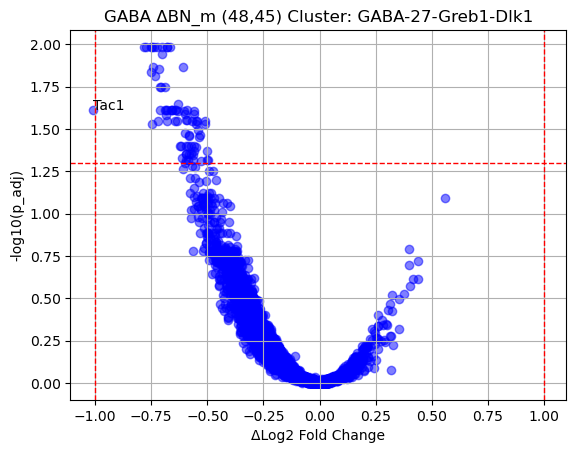

<Figure size 640x480 with 0 Axes>

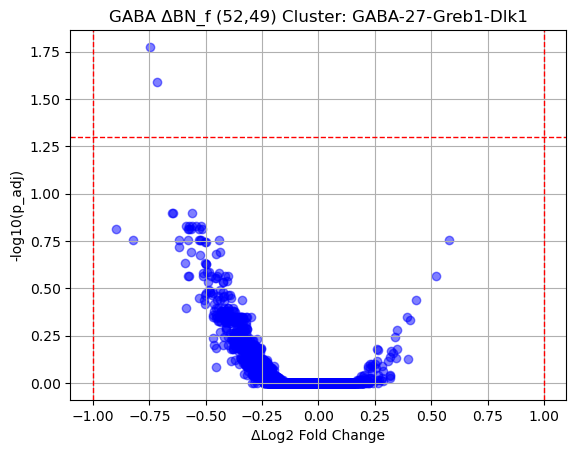

<Figure size 640x480 with 0 Axes>

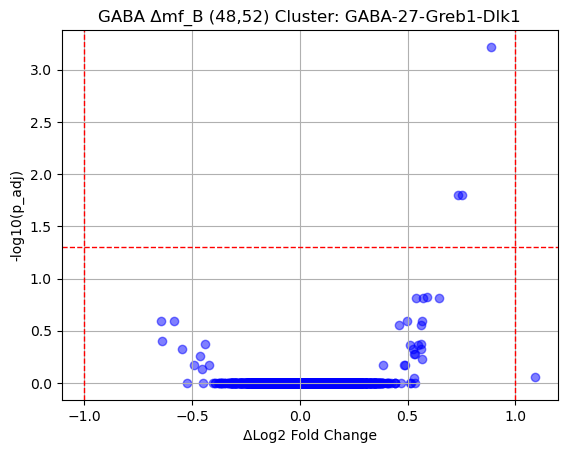

<Figure size 640x480 with 0 Axes>

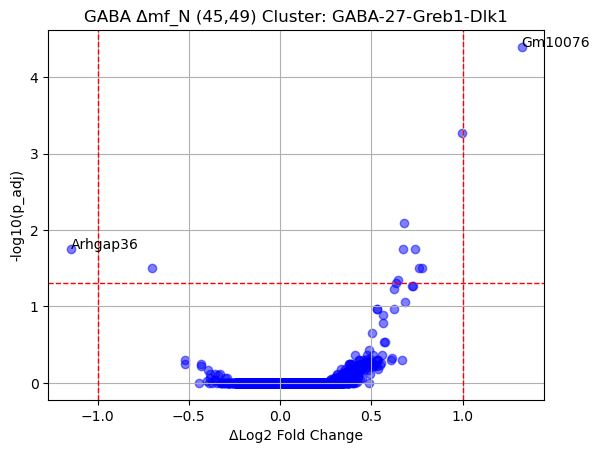

running volcano analysis on cluster  GABA-28-Lypd1-Satb1 ...


<Figure size 640x480 with 0 Axes>

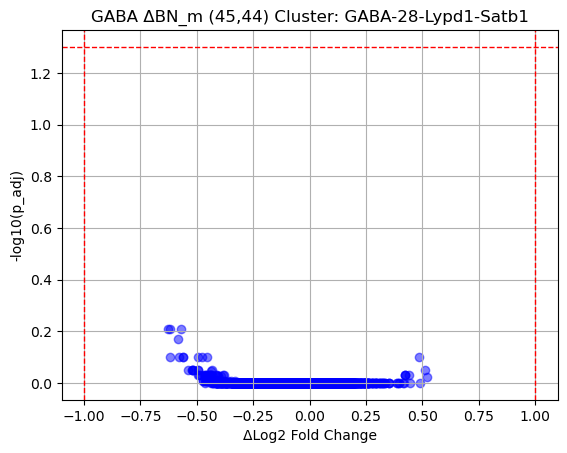

<Figure size 640x480 with 0 Axes>

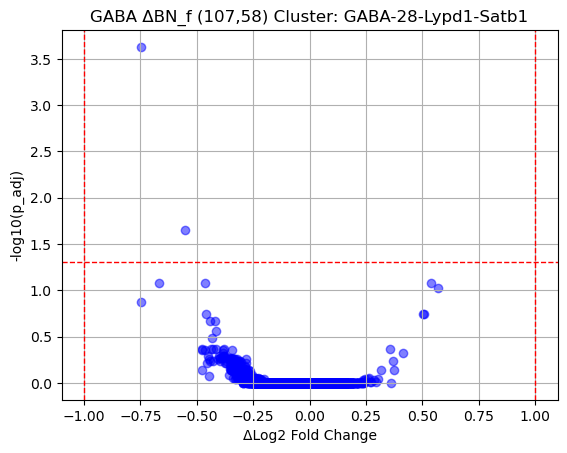

<Figure size 640x480 with 0 Axes>

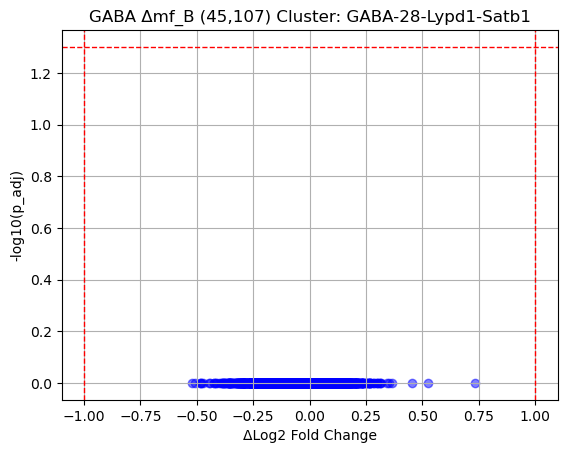

<Figure size 640x480 with 0 Axes>

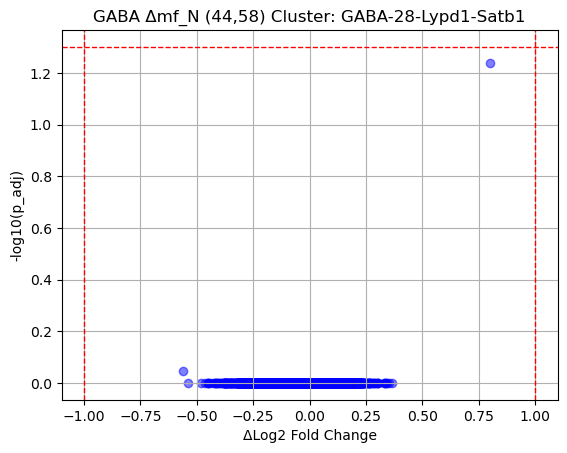

running volcano analysis on cluster  GABA-29-Lpyd1-Unc13c ...


<Figure size 640x480 with 0 Axes>

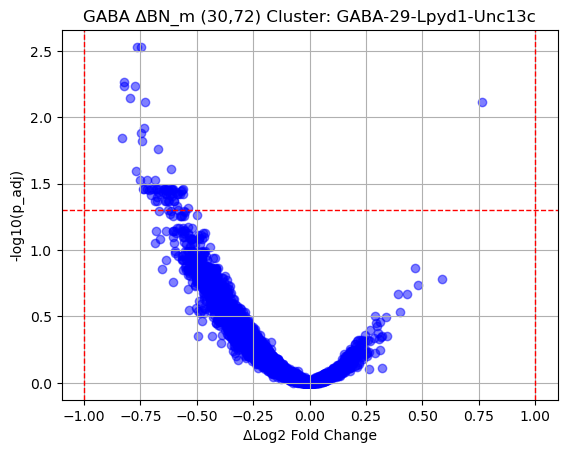

<Figure size 640x480 with 0 Axes>

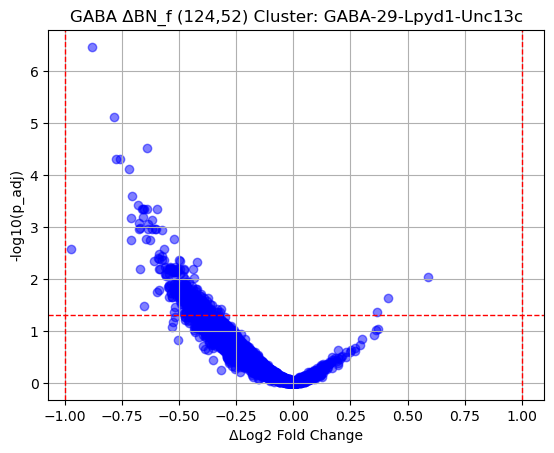

<Figure size 640x480 with 0 Axes>

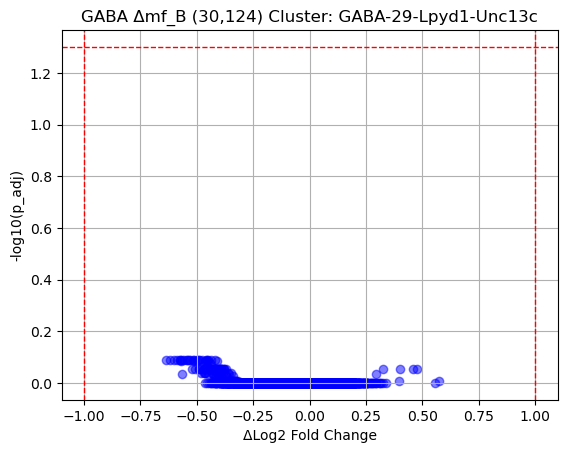

<Figure size 640x480 with 0 Axes>

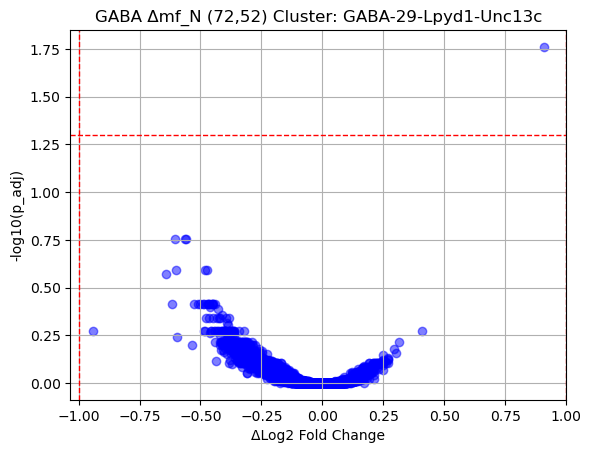

running volcano analysis on cluster  GABA-30-Cbln4-Zbtb20 ...


<Figure size 640x480 with 0 Axes>

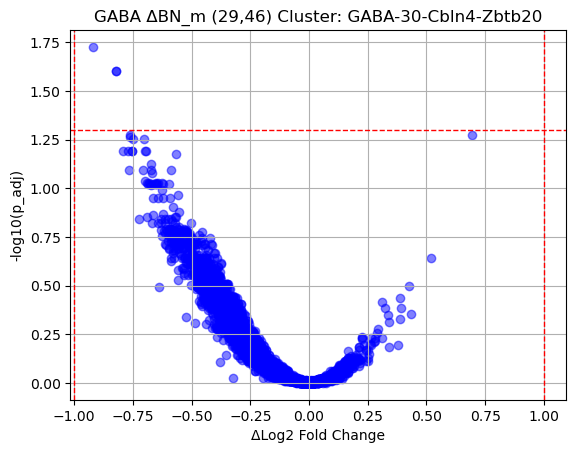

<Figure size 640x480 with 0 Axes>

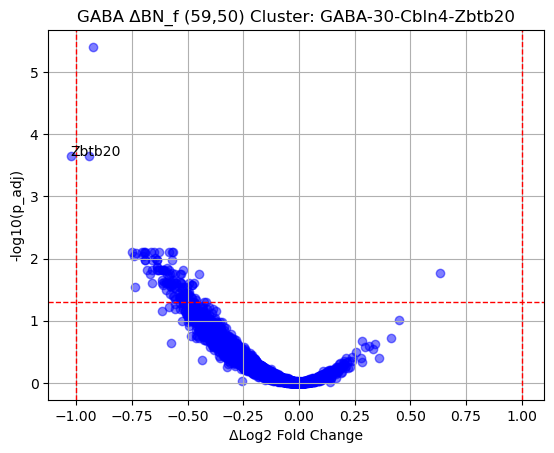

<Figure size 640x480 with 0 Axes>

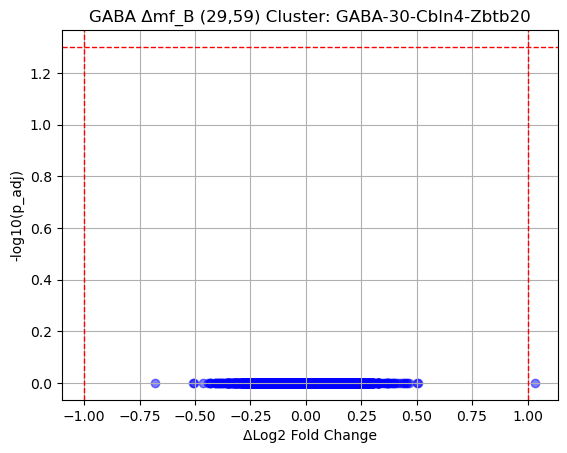

<Figure size 640x480 with 0 Axes>

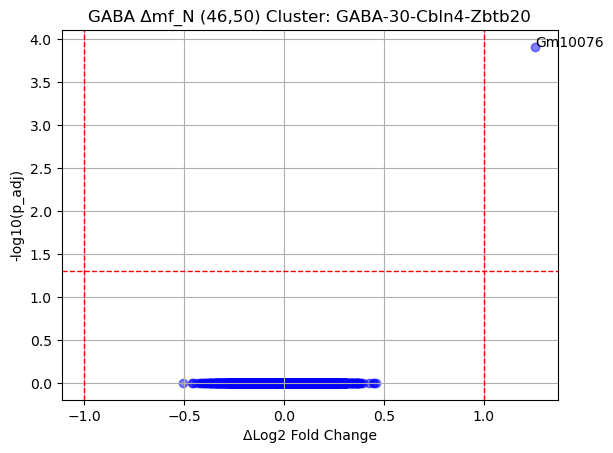

running volcano analysis on cluster  GABA-31-Fign-Foxp2 ...


<Figure size 640x480 with 0 Axes>

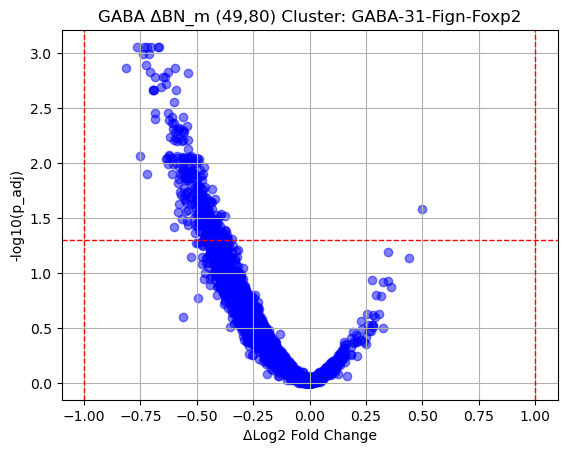

<Figure size 640x480 with 0 Axes>

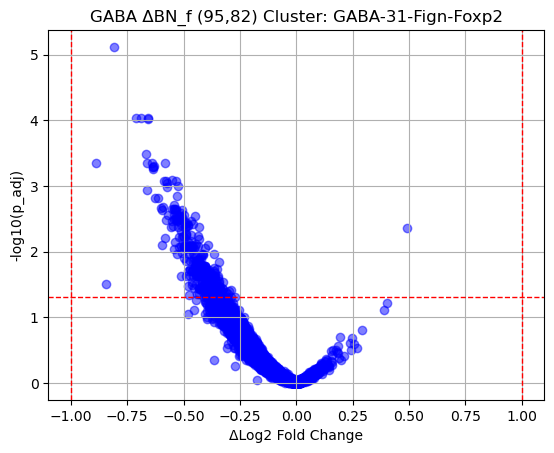

<Figure size 640x480 with 0 Axes>

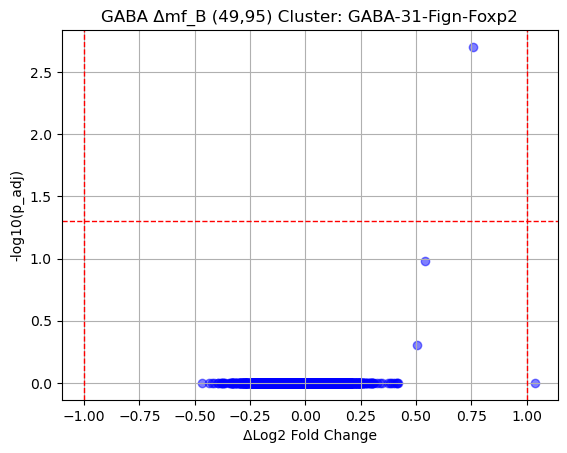

<Figure size 640x480 with 0 Axes>

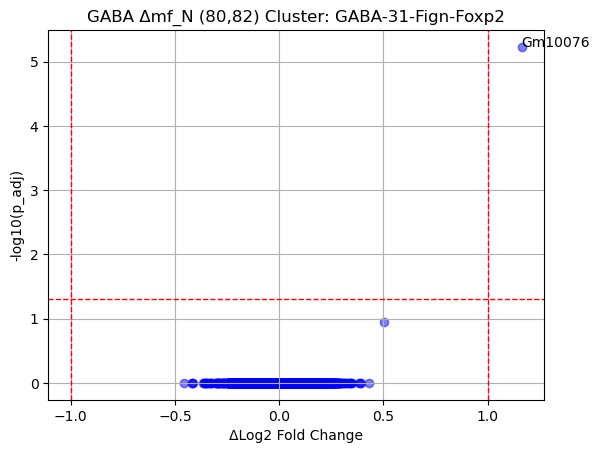

running volcano analysis on cluster  GABA-33-Cartpt-Unc13c ...


<Figure size 640x480 with 0 Axes>

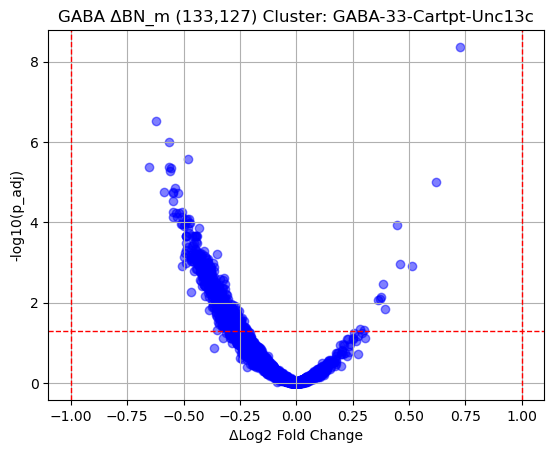

<Figure size 640x480 with 0 Axes>

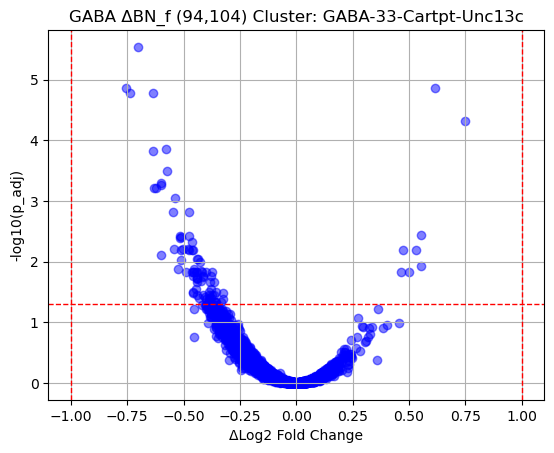

/home/isaac/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

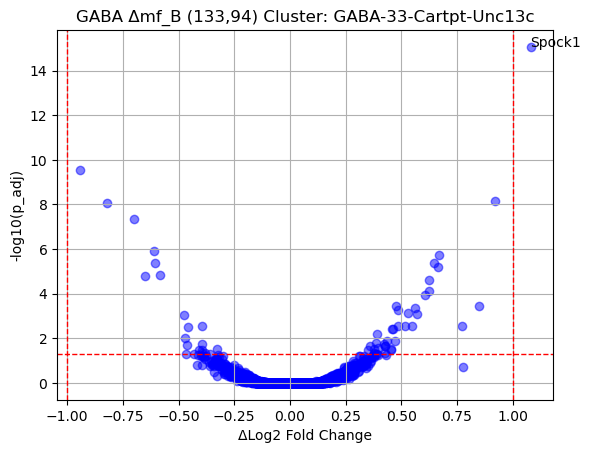

/home/isaac/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

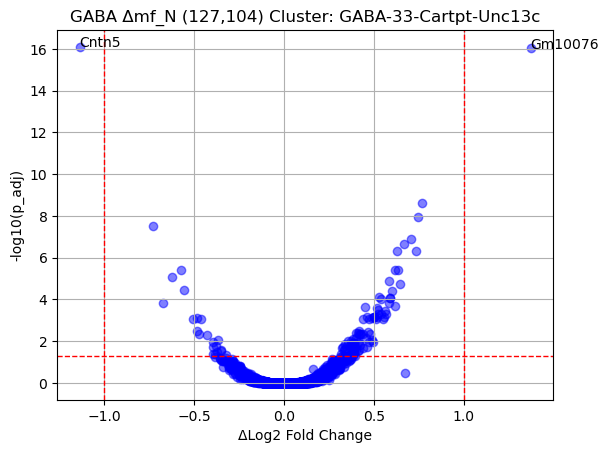

complete. results in:  /bigdata/isaac/gaba_files/sex_stats/volcano_plots/171224_run/


In [133]:
for c in gaba_fn:
    print ('running volcano analysis on cluster ', c, '...')
    _, _, _, _ = ss.run_volcano_analysis(gaba_delta_data_folder, gaba_utest_output_folder,gaba_volcano_output_folder, c, 'GABA', gaba_all_counts_df, savefig = True, write_to_file = True)
print('complete. results in: ', gaba_volcano_output_folder)

In [141]:
gaba_sig_genes_df = pd.read_csv(gaba_volcano_output_folder + 'sig_genes.csv',header=None)

In [135]:
gaba_volcano_output_folder

'/bigdata/isaac/gaba_files/sex_stats/volcano_plots/171224_run/'

In [ ]:
#test on single cluster
expr_mlog_df_sig_mode,counts_df_sig_mode = ss.compute_group_gene_expression_differences(gaba_df_dlr,
                                                            gaba_metadata_df_dlr,
                                                            cluster_fn='GABA-14-Isl1-Gal',
                                                            threshold_prc_h=70,
                                                            threshold_prc_l=10, 
                                                            r_bn = 2, 
                                                            r_mf = 2, 
                                                            cell_class='GABA', 
                                                            folder = gaba_delta_folder,
                                                            normalize = True,
                                                            n_factor = 20000,          
                                                            mode = 'sig_genes',
                                                            sig_genes_df = gaba_sig_genes_df,
                                                            savefig = True, 
                                                            write_to_file=True)

(7256, 500)


(7256, 334)
Finished processing cluster:  GABA-1-Sst-Npy-Spon1
(7256, 288)
Finished processing cluster:  GABA-2-Sst-Npy-Maf
(7256, 337)
Finished processing cluster:  GABA-4-Moxd1-Pvalb
(7256, 178)
Finished processing cluster:  GABA-5-Moxd1-Vwc2
(7256, 64)
Finished processing cluster:  GABA-6-Hapln1-Cryab
(7256, 283)
Finished processing cluster:  GABA-7-Vip-Crh
(7256, 216)
Finished processing cluster:  GABA-8-Htr3a-Rgs12
(7256, 688)
Finished processing cluster:  GABA-9-Dab1-Myh7
(7256, 145)
Finished processing cluster:  GABA-10-Pax6-Npnt
(7256, 156)
Finished processing cluster:  GABA-11-Pax6-Calca
(7256, 147)
Finished processing cluster:  GABA-12-Sncg-Reln
(7256, 230)
Finished processing cluster:  GABA-13-Fign-Lrpprc
(7256, 223)


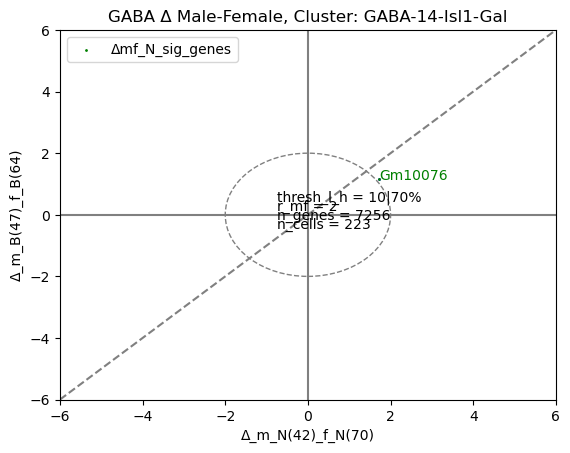

Finished processing cluster:  GABA-14-Isl1-Gal
(7256, 127)
Finished processing cluster:  GABA-15-Igsf1-Zfhx3
(7256, 166)
Finished processing cluster:  GABA-17-Isl1-Pou3f2
(7256, 447)
Finished processing cluster:  GABA-19-Meis2-Tshz1
(7256, 162)
Finished processing cluster:  GABA-20-Meis2-Foxp2
(7256, 299)
Finished processing cluster:  GABA-21-Meis2-Nwd2
(7256, 282)
Finished processing cluster:  GABA-22-Col23a1-Hs3st4
(7256, 289)
Finished processing cluster:  GABA-23-Pde11a-Npy2r
(7256, 582)
Finished processing cluster:  GABA-24-Prlr-St18
(7256, 500)
Finished processing cluster:  GABA-25-Oprk1-Trhde
(7256, 391)
Finished processing cluster:  GABA-26-Col18a1-Jsrp1
(7256, 194)
Finished processing cluster:  GABA-27-Greb1-Dlk1
(7256, 254)
Finished processing cluster:  GABA-28-Lypd1-Satb1
(7256, 278)
Finished processing cluster:  GABA-29-Lpyd1-Unc13c
(7256, 184)
Finished processing cluster:  GABA-30-Cbln4-Zbtb20
(7256, 306)
Finished processing cluster:  GABA-31-Fign-Foxp2
(7256, 458)
Finished

In [142]:
#run over all clusters in sig gene mode
for c in gaba_fn:
    _,_ = ss.compute_group_gene_expression_differences(gaba_df_dlr,
                                                        gaba_metadata_df_dlr,
                                                        cluster_fn=c,
                                                        threshold_prc_h=70,
                                                        threshold_prc_l=10, 
                                                        r_bn = 2, 
                                                        r_mf = 2, 
                                                        cell_class='GABA', 
                                                        folder = gaba_delta_folder,
                                                        normalize = True,
                                                        n_factor = 20000,          
                                                        mode = 'sig_genes',
                                                        sig_genes_df = gaba_sig_genes_df,
                                                        savefig = True, 
                                                        write_to_file=True)
    print ('Finished processing cluster: ', c)
print ('Run complete, results in: ', gaba_delta_folder)